In [121]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import gridspec
from matplotlib import patches
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import json

import os
import math
import random

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.metrics import roc_curve, roc_auc_score, auc

import scipy.stats as st
from scipy.stats import poisson
from scipy.interpolate import interp1d
from scipy.stats import norm


from sklearn.neighbors import KernelDensity 
from sklearn.model_selection import GridSearchCV

import scipy.integrate as integrate


import xgboost
from xgboost import XGBRegressor, XGBClassifier

from tqdm import tqdm

In [2]:
#####################################
# IMPORT AUXILIARY/CUSTOM FUNCTIONS #
#####################################

from AUX_MLL_BL import XG, KDE_fitter, max_num_bins
from AUX_MLL_BL import Z_BL_asimov, BL_test_fast, BL_test_fsolve, MLL_test_fast, MLL_test_fsolve

In [3]:
import matplotlib as mpl
mpl.rc('xtick', labelsize=12) 
mpl.rc('ytick', labelsize=12) 

In [4]:
BPs2plot = [2,5,8,11,14]
cmap = cm.get_cmap('Blues', 18)
#cmap = ['coral']
wjets_color = 'coral'
wgamma_color = 'red'
ttgamma_color = 'purple'

# custom functions

In [5]:
def MLL_aprox_discovery_ox(pred_XG_SM, pred_XG_NP, B_expected, S_expected):
   
    pspb_B_data = np.median([im / (1 - im) for im in pred_XG_SM])
    pspb_S_data = np.median([im / (1 - im) for im in pred_XG_NP])
   
    f0 = -2 * S_expected
    fB = 2 * B_expected * np.log( 1 + (pspb_B_data * S_expected / B_expected) )
    fS = 2 * S_expected * np.log( 1 + (pspb_S_data * S_expected / B_expected) )
   
    return (f0 + fB + fS)**0.5



def MLL_aprox_discovery_KDE(pB_B_data, pS_B_data, pB_S_data, pS_S_data, B_expected, S_expected):
   
    pspb_B_data = np.median(pS_B_data/pB_B_data)
    pspb_S_data = np.median(pS_S_data/pB_S_data)
   
    f0 = -2 * S_expected
    fB = 2 * B_expected * np.log( 1 + (pspb_B_data * S_expected / B_expected) )
    fS = 2 * S_expected * np.log( 1 + (pspb_S_data * S_expected / B_expected) )
   
    return (f0 + fB + fS)**0.5


# Reading the data

In [6]:
ttgamma_cross = 0.144 * 1000 #[fb]
ttgamma_NLO   = 1.46 # k-factor [14 TeV]

Wgamma_cross = 0.944 * 1000 #[fb]
Wgamma_NLO   = 2.37 # k-factor [14 TeV]

Wjets_cross = 168.12 * 1000 #[fb]
Wjets_NLO   = 1.27 # k-factor [14 TeV]

In [7]:
Wgamma_fidcross  = 584.6234734948906
Wjets_fidcross   = 600.5788869631236
ttgamma_fidcross = 28.773979008
B_fidcross_tot   = Wgamma_fidcross + Wjets_fidcross + ttgamma_fidcross
B_fidcross_tot

1213.9763394660142

In [8]:
Wjets_aceptancia_init   = Wjets_fidcross / (Wjets_cross * 1000 * Wjets_NLO)
Wgamma_aceptancia_init  = Wgamma_fidcross / (Wgamma_cross * 1000 * Wgamma_NLO)
ttgamma_aceptancia_init = ttgamma_fidcross / (ttgamma_cross * 1000 * ttgamma_NLO)

In [83]:
Wgamma_expected  = 58462.347349489064
Wjets_expected   = 60057.888696312366
ttgamma_expected = 2877.3979008
B_expected = (ttgamma_expected + Wjets_expected + Wgamma_expected)

In [10]:
sample = 200_000 # Number of signal and background events to train and validate

Wgamma_sample  = int(round(sample * Wgamma_fidcross / B_fidcross_tot))
Wjets_sample   = int(round(sample * Wjets_fidcross / B_fidcross_tot))
ttgamma_sample = int(round(sample * ttgamma_fidcross / B_fidcross_tot))

print(Wgamma_sample)
print(Wjets_sample)
print(ttgamma_sample)

96315
98944
4740


In [11]:
##############
# input data #
##############

# photon -> (pT, eta, phi, num_photon) from the leading photon
# jet -> (pT, eta, phi) from the leading jet
# lepton -> (pT, eta, phi, num_leptons, num_taus) from the lepton (electron or muon)
# MET -> (pT, eta, phi) eta = 0 by construction, but phi is important because we have a lot of jets that we do not use
# hadinfo -> (HT, HT_had, num_jets)  HT: sum of Pt of all partciles, HT_had: sum PT of all the jets, number of jets (b-tag or not)


######
# SM #
######

# W gamma + W gamma jet #
# Dominant # Np es el W jet el dominant??

datFolderWgamma = '../data/Wgamma/'

photon_Wgamma  = np.loadtxt(datFolderWgamma + 'photon_4.dat', delimiter=' ')
jet_Wgamma     = np.loadtxt(datFolderWgamma + 'jet_4.dat', delimiter=' ')
lepton_Wgamma  = np.loadtxt(datFolderWgamma + 'lepton_4.dat', delimiter=' ')
MET_Wgamma     = np.loadtxt(datFolderWgamma + 'MET_4.dat', delimiter=' ')
hadinfo_Wgamma = np.loadtxt(datFolderWgamma + 'hadinfo_4.dat', delimiter=' ')


# W jet + W jet jet #

datFolderWjets = '../data/Wjets/'

photon_Wjets  = np.loadtxt(datFolderWjets + 'photon_4.dat', delimiter=' ')
jet_Wjets     = np.loadtxt(datFolderWjets + 'jet_4.dat', delimiter=' ')
lepton_Wjets  = np.loadtxt(datFolderWjets + 'lepton_4.dat', delimiter=' ')
MET_Wjets     = np.loadtxt(datFolderWjets + 'MET_4.dat', delimiter=' ')
hadinfo_Wjets = np.loadtxt(datFolderWjets + 'hadinfo_4.dat', delimiter=' ')


# tt gamma + tt gamma jet #

datFolderttgamma = '../data/ttGamma/'
 
photon_ttgamma  = np.loadtxt(datFolderttgamma + 'photon_4.dat', delimiter=' ')
jet_ttgamma     = np.loadtxt(datFolderttgamma + 'jet_4.dat', delimiter=' ')
lepton_ttgamma  = np.loadtxt(datFolderttgamma + 'lepton_4.dat', delimiter=' ')
MET_ttgamma     = np.loadtxt(datFolderttgamma + 'MET_4.dat', delimiter=' ')
hadinfo_ttgamma = np.loadtxt(datFolderttgamma + 'hadinfo_4.dat', delimiter=' ')


photon_SM  = np.concatenate([photon_Wgamma[:Wgamma_sample], photon_Wjets[:Wjets_sample], photon_ttgamma[:ttgamma_sample]])
jet_SM     = np.concatenate([jet_Wgamma[:Wgamma_sample], jet_Wjets[:Wjets_sample], jet_ttgamma[:ttgamma_sample]]) 
lepton_SM  = np.concatenate([lepton_Wgamma[:Wgamma_sample], lepton_Wjets[:Wjets_sample], lepton_ttgamma[:ttgamma_sample]])
MET_SM     = np.concatenate([MET_Wgamma[:Wgamma_sample], MET_Wjets[:Wjets_sample], MET_ttgamma[:ttgamma_sample]])
hadinfo_SM = np.concatenate([hadinfo_Wgamma[:Wgamma_sample], hadinfo_Wjets[:Wjets_sample], hadinfo_ttgamma[:ttgamma_sample]])


In [12]:
bkg_flag = np.zeros(len(photon_SM))

bkg_flag[:Wgamma_sample] = 1
bkg_flag[Wgamma_sample:(Wgamma_sample + Wjets_sample)] = 2
bkg_flag[(Wgamma_sample + Wjets_sample):len(photon_SM)] = 3

In [13]:
wjets_pool  = len(photon_Wjets[Wjets_sample:])
pool_sample = int(wjets_pool * B_fidcross_tot / Wjets_fidcross)

Wgamma_pool_sample  = int(round(pool_sample * Wgamma_fidcross / B_fidcross_tot))
Wjets_pool_sample   = int(round(pool_sample * Wjets_fidcross / B_fidcross_tot))
ttgamma_pool_sample = int(round(pool_sample * ttgamma_fidcross / B_fidcross_tot))

print(Wgamma_pool_sample)
print(Wjets_pool_sample)
print(ttgamma_pool_sample)

156139
160401
7685


In [14]:
photon_SM_pool  = np.concatenate([photon_Wgamma[Wgamma_sample:(Wgamma_sample + Wgamma_pool_sample)],
                                  photon_Wjets[Wjets_sample:(Wjets_sample + Wjets_pool_sample)],
                                  photon_ttgamma[ttgamma_sample:(ttgamma_sample + ttgamma_pool_sample)]])
jet_SM_pool     = np.concatenate([jet_Wgamma[Wgamma_sample:(Wgamma_sample + Wgamma_pool_sample)],
                                  jet_Wjets[Wjets_sample:(Wjets_sample + Wjets_pool_sample)],
                                  jet_ttgamma[ttgamma_sample:(ttgamma_sample + ttgamma_pool_sample)]]) 
lepton_SM_pool  = np.concatenate([lepton_Wgamma[Wgamma_sample:(Wgamma_sample + Wgamma_pool_sample)],
                                  lepton_Wjets[Wjets_sample:(Wjets_sample + Wjets_pool_sample)],
                                  lepton_ttgamma[ttgamma_sample:(ttgamma_sample + ttgamma_pool_sample)]])
MET_SM_pool     = np.concatenate([MET_Wgamma[Wgamma_sample:(Wgamma_sample + Wgamma_pool_sample)],
                                  MET_Wjets[Wjets_sample:(Wjets_sample + Wjets_pool_sample)],
                                  MET_ttgamma[ttgamma_sample:(ttgamma_sample + ttgamma_pool_sample)]])
hadinfo_SM_pool = np.concatenate([hadinfo_Wgamma[Wgamma_sample:(Wgamma_sample + Wgamma_pool_sample)],
                                  hadinfo_Wjets[Wjets_sample:(Wjets_sample + Wjets_pool_sample)],
                                  hadinfo_ttgamma[ttgamma_sample:(ttgamma_sample + ttgamma_pool_sample)]])

In [15]:
bkg_flag_pool = np.zeros(len(photon_SM_pool))

bkg_flag_pool[:Wgamma_pool_sample] = 1
bkg_flag_pool[Wgamma_pool_sample:(Wgamma_pool_sample + Wjets_pool_sample)] = 2
bkg_flag_pool[(Wgamma_pool_sample + Wjets_pool_sample):] = 3

In [16]:
print(photon_Wjets.shape)
print(photon_ttgamma.shape)
print(photon_Wgamma.shape)

(259345, 4)
(2052938, 4)
(3579946, 4)


In [17]:
######
# NP #
######

datFolderNP = '../data/Signal/'

photon_NP  = []
jet_NP     = []
lepton_NP  = []
MET_NP     = []
hadinfo_NP = []
name       = []
for i in [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]:
    name.append('BP' + str(i))
    photon_NP.append( np.loadtxt(datFolderNP + 'BP' + str(i) + '_photon_4.dat', delimiter=' ') )
    jet_NP.append( np.loadtxt(datFolderNP + 'BP' + str(i) + '_jet_4.dat', delimiter=' ') )
    lepton_NP.append( np.loadtxt(datFolderNP + 'BP' + str(i) + '_lepton_4.dat', delimiter=' ') )
    MET_NP.append( np.loadtxt(datFolderNP + 'BP' + str(i) + '_MET_4.dat', delimiter=' ') )
    hadinfo_NP.append( np.loadtxt(datFolderNP + 'BP' + str(i) + '_hadinfo_4.dat', delimiter=' ') )

In [18]:
print('SM', lepton_SM.shape)
for i in range(len(jet_NP)):
    print(name[i], lepton_NP[i].shape)

SM (199999, 5)
BP1 (238160, 5)
BP2 (246196, 5)
BP3 (242249, 5)
BP4 (301575, 5)
BP5 (266047, 5)
BP6 (203155, 5)
BP7 (315960, 5)
BP8 (280065, 5)
BP9 (225958, 5)
BP10 (326687, 5)
BP11 (292051, 5)
BP12 (244271, 5)
BP13 (334782, 5)
BP14 (301215, 5)
BP15 (258277, 5)


In [19]:
cross_section_bps    = np.asarray([190, 189, 189, 92, 92, 92, 49, 48, 48, 27, 27, 27, 16, 16, 16])
branching_ratios_bps = np.asarray([0.14, 0.37, 0.73, 0.15, 0.36, 0.67, 0.16, 0.36, 0.62, 0.17, 0.35, 0.58, 0.16, 0.32, 0.52])

signal_cross        = cross_section_bps * branching_ratios_bps *  0.2134 # fb
signal_init_sim_eve = np.asarray([836673,1e6,1.4e6,1e6,1e6,1e6,1e6,1e6,1e6,1e6,1e6,1e6,1e6,1e6,1e6])
signal_cut_ev       = np.asarray([238160,246196,242249,301575,266047,203155,315960,280065,225958,326687,292051,244271,334782,301215,258277])
signal_NLO          = 1.25

cross       = signal_cross * signal_NLO
aceptancia  = signal_cut_ev / (1. * signal_init_sim_eve)
luminosidad = 100

signal_fidcross = cross * aceptancia
S_expected = cross * aceptancia * luminosidad

print('fiducial cross section: ', signal_fidcross)
print('Events expected: ', S_expected)

fiducial cross section:  [2.01975705 4.59249772 6.36829319 1.11014281 2.35046139 3.34036999
 0.66077347 1.29094281 1.79376306 0.39998985 0.73619851 1.02039447
 0.22861593 0.4113874  0.57320964]
Events expected:  [201.97570473 459.24977152 636.82931899 111.01428112 235.04613937
 334.03699928  66.07734672 129.09428136 179.37630638  39.99898458
  73.61985102 102.03944697  22.86159322  41.13873984  57.32096427]


In [20]:
# other variables, individual channels:

ST_Wgamma = photon_Wgamma[:,0] + lepton_Wgamma[:,0] + jet_Wgamma[:,0]

MET_sig_Wgamma = np.divide( MET_Wgamma[:,0], np.sqrt(hadinfo_Wgamma[:,0]) )

m_eff_Wgamma = MET_Wgamma[:,0] + photon_Wgamma[:,0] + lepton_Wgamma[:,0] + jet_Wgamma[:,0]

phi_MET_photon_Wgamma = np.absolute( MET_Wgamma[:,2] - photon_Wgamma[:,2] )
phi_MET_jet_Wgamma    = np.absolute( MET_Wgamma[:,2] - jet_Wgamma[:,2] )
phi_MET_lepton_Wgamma = np.absolute( MET_Wgamma[:,2] - lepton_Wgamma[:,2] )

mT_photon_Wgamma = np.sqrt( (2*photon_Wgamma[:,0]*MET_Wgamma[:,0]) * (1 - np.cos(phi_MET_photon_Wgamma)) )
mT_jet_Wgamma    = np.sqrt( (2*jet_Wgamma[:,0]*MET_Wgamma[:,0]) * (1 - np.cos(phi_MET_jet_Wgamma)) )
mT_lepton_Wgamma = np.sqrt( (2*lepton_Wgamma[:,0]*MET_Wgamma[:,0]) * (1 - np.cos(phi_MET_lepton_Wgamma)) )

phi_photon_jet_Wgamma    = np.absolute( photon_Wgamma[:,2] - jet_Wgamma[:,2] )
phi_photon_lepton_Wgamma = np.absolute( photon_Wgamma[:,2] - lepton_Wgamma[:,2] )
phi_lepton_jet_Wgamma    = np.absolute( lepton_Wgamma[:,2] - jet_Wgamma[:,2] )

phi_photon_jet_Wgamma[phi_photon_jet_Wgamma>np.pi]       = (2.* np.pi) - phi_photon_jet_Wgamma[phi_photon_jet_Wgamma>np.pi]
phi_photon_lepton_Wgamma[phi_photon_lepton_Wgamma>np.pi] = (2.* np.pi) - phi_photon_lepton_Wgamma[phi_photon_lepton_Wgamma>np.pi]
phi_lepton_jet_Wgamma[phi_lepton_jet_Wgamma>np.pi]       = (2.* np.pi) - phi_lepton_jet_Wgamma[phi_lepton_jet_Wgamma>np.pi]

deltaR_photon_jet_Wgamma    = np.sqrt( (photon_Wgamma[:,1]-jet_Wgamma[:,1])**2 + (phi_photon_jet_Wgamma)**2 )
deltaR_photon_lepton_Wgamma = np.sqrt( (photon_Wgamma[:,1]-lepton_Wgamma[:,1])**2 + (phi_photon_lepton_Wgamma)**2 )
deltaR_lepton_jet_Wgamma    = np.sqrt( (lepton_Wgamma[:,1]-jet_Wgamma[:,1])**2 + (phi_lepton_jet_Wgamma)**2 )

ST_Wjets = photon_Wjets[:,0]+lepton_Wjets[:,0]+jet_Wjets[:,0]

MET_sig_Wjets = np.divide( MET_Wjets[:,0],np.sqrt(hadinfo_Wjets[:,0]) )

m_eff_Wjets = MET_Wjets[:,0] + photon_Wjets[:,0]+lepton_Wjets[:,0]+jet_Wjets[:,0]

phi_MET_photon_Wjets = np.absolute( MET_Wjets[:,2] - photon_Wjets[:,2] )
phi_MET_jet_Wjets    = np.absolute( MET_Wjets[:,2] - jet_Wjets[:,2] )
phi_MET_lepton_Wjets = np.absolute( MET_Wjets[:,2] - lepton_Wjets[:,2] )

mT_photon_Wjets = np.sqrt( (2*photon_Wjets[:,0]*MET_Wjets[:,0]) * (1 - np.cos(phi_MET_photon_Wjets)) )
mT_jet_Wjets    = np.sqrt( (2*jet_Wjets[:,0]*MET_Wjets[:,0]) * (1 - np.cos(phi_MET_jet_Wjets)) )
mT_lepton_Wjets = np.sqrt( (2*lepton_Wjets[:,0]*MET_Wjets[:,0]) * (1 - np.cos(phi_MET_lepton_Wjets)) )

phi_photon_jet_Wjets    = np.absolute( photon_Wjets[:,2] - jet_Wjets[:,2] )
phi_photon_lepton_Wjets = np.absolute( photon_Wjets[:,2] - lepton_Wjets[:,2] )
phi_lepton_jet_Wjets    = np.absolute( lepton_Wjets[:,2] - jet_Wjets[:,2] )

phi_photon_jet_Wjets[phi_photon_jet_Wjets>np.pi]       = (2.* np.pi) - phi_photon_jet_Wjets[phi_photon_jet_Wjets>np.pi]
phi_photon_lepton_Wjets[phi_photon_lepton_Wjets>np.pi] = (2.* np.pi) - phi_photon_lepton_Wjets[phi_photon_lepton_Wjets>np.pi]
phi_lepton_jet_Wjets[phi_lepton_jet_Wjets>np.pi]       = (2.* np.pi) - phi_lepton_jet_Wjets[phi_lepton_jet_Wjets>np.pi]

deltaR_photon_jet_Wjets    = np.sqrt( (photon_Wjets[:,1]-jet_Wjets[:,1])**2 + (phi_photon_jet_Wjets)**2 )
deltaR_photon_lepton_Wjets = np.sqrt( (photon_Wjets[:,1]-lepton_Wjets[:,1])**2 + (phi_photon_lepton_Wjets)**2 )
deltaR_lepton_jet_Wjets    = np.sqrt( (lepton_Wjets[:,1]-jet_Wjets[:,1])**2 + (phi_lepton_jet_Wjets)**2 )



ST_ttgamma = photon_ttgamma[:,0]+lepton_ttgamma[:,0]+jet_ttgamma[:,0]

MET_sig_ttgamma = np.divide( MET_ttgamma[:,0],np.sqrt(hadinfo_ttgamma[:,0]) )

m_eff_ttgamma = MET_ttgamma[:,0] + photon_ttgamma[:,0]+lepton_ttgamma[:,0]+jet_ttgamma[:,0]

phi_MET_photon_ttgamma = np.absolute( MET_ttgamma[:,2] - photon_ttgamma[:,2] )
phi_MET_jet_ttgamma    = np.absolute( MET_ttgamma[:,2] - jet_ttgamma[:,2] )
phi_MET_lepton_ttgamma = np.absolute( MET_ttgamma[:,2] - lepton_ttgamma[:,2] )

mT_photon_ttgamma = np.sqrt( (2*photon_ttgamma[:,0]*MET_ttgamma[:,0]) * (1 - np.cos(phi_MET_photon_ttgamma)) )
mT_jet_ttgamma    = np.sqrt( (2*jet_ttgamma[:,0]*MET_ttgamma[:,0]) * (1 - np.cos(phi_MET_jet_ttgamma)) )
mT_lepton_ttgamma = np.sqrt( (2*lepton_ttgamma[:,0]*MET_ttgamma[:,0]) * (1 - np.cos(phi_MET_lepton_ttgamma)) )

phi_photon_jet_ttgamma    = np.absolute( photon_ttgamma[:,2] - jet_ttgamma[:,2] )
phi_photon_lepton_ttgamma = np.absolute( photon_ttgamma[:,2] - lepton_ttgamma[:,2] )
phi_lepton_jet_ttgamma    = np.absolute( lepton_ttgamma[:,2] - jet_ttgamma[:,2] )

phi_photon_jet_ttgamma[phi_photon_jet_ttgamma>np.pi]       = (2.* np.pi) - phi_photon_jet_ttgamma[phi_photon_jet_ttgamma>np.pi]
phi_photon_lepton_ttgamma[phi_photon_lepton_ttgamma>np.pi] = (2.* np.pi) - phi_photon_lepton_ttgamma[phi_photon_lepton_ttgamma>np.pi]
phi_lepton_jet_ttgamma[phi_lepton_jet_ttgamma>np.pi]       = (2.* np.pi) - phi_lepton_jet_ttgamma[phi_lepton_jet_ttgamma>np.pi]

deltaR_photon_jet_ttgamma    = np.sqrt( (photon_ttgamma[:,1]-jet_ttgamma[:,1])**2 + (phi_photon_jet_ttgamma)**2 )
deltaR_photon_lepton_ttgamma = np.sqrt( (photon_ttgamma[:,1]-lepton_ttgamma[:,1])**2 + (phi_photon_lepton_ttgamma)**2 )
deltaR_lepton_jet_ttgamma    = np.sqrt( (lepton_ttgamma[:,1]-jet_ttgamma[:,1])**2 + (phi_lepton_jet_ttgamma)**2 )



# other variables

ST_SM = photon_SM[:,0]+lepton_SM[:,0]+jet_SM[:,0]

MET_sig_SM = np.divide( MET_SM[:,0],np.sqrt(hadinfo_SM[:,0]) )

m_eff_SM = MET_SM[:,0] + photon_SM[:,0]+lepton_SM[:,0]+jet_SM[:,0]

phi_MET_photon_SM = np.absolute( MET_SM[:,2] - photon_SM[:,2] )
phi_MET_jet_SM    = np.absolute( MET_SM[:,2] - jet_SM[:,2] )
phi_MET_lepton_SM = np.absolute( MET_SM[:,2] - lepton_SM[:,2] )

mT_photon_SM = np.sqrt( (2*photon_SM[:,0]*MET_SM[:,0]) * (1 - np.cos(phi_MET_photon_SM)) )
mT_jet_SM    = np.sqrt( (2*jet_SM[:,0]*MET_SM[:,0]) * (1 - np.cos(phi_MET_jet_SM)) )
mT_lepton_SM = np.sqrt( (2*lepton_SM[:,0]*MET_SM[:,0]) * (1 - np.cos(phi_MET_lepton_SM)) )

phi_photon_jet_SM    = np.absolute( photon_SM[:,2] - jet_SM[:,2] )
phi_photon_lepton_SM = np.absolute( photon_SM[:,2] - lepton_SM[:,2] )
phi_lepton_jet_SM    = np.absolute( lepton_SM[:,2] - jet_SM[:,2] )

phi_photon_jet_SM[phi_photon_jet_SM>np.pi]       = (2.* np.pi) - phi_photon_jet_SM[phi_photon_jet_SM>np.pi]
phi_photon_lepton_SM[phi_photon_lepton_SM>np.pi] = (2.* np.pi) - phi_photon_lepton_SM[phi_photon_lepton_SM>np.pi]
phi_lepton_jet_SM[phi_lepton_jet_SM>np.pi]       = (2.* np.pi) - phi_lepton_jet_SM[phi_lepton_jet_SM>np.pi]

deltaR_photon_jet_SM    = np.sqrt( (photon_SM[:,1]-jet_SM[:,1])**2 + (phi_photon_jet_SM)**2 )
deltaR_photon_lepton_SM = np.sqrt( (photon_SM[:,1]-lepton_SM[:,1])**2 + (phi_photon_lepton_SM)**2 )
deltaR_lepton_jet_SM    = np.sqrt( (lepton_SM[:,1]-jet_SM[:,1])**2 + (phi_lepton_jet_SM)**2 )

In [21]:
# other variables, individual channels pool sample:

ST_SM_pool = photon_SM_pool[:,0]+lepton_SM_pool[:,0]+jet_SM_pool[:,0]

MET_sig_SM_pool = np.divide( MET_SM_pool[:,0],np.sqrt(hadinfo_SM_pool[:,0]) )

m_eff_SM_pool = MET_SM_pool[:,0] + photon_SM_pool[:,0]+lepton_SM_pool[:,0]+jet_SM_pool[:,0]

phi_MET_photon_SM_pool = np.absolute( MET_SM_pool[:,2] - photon_SM_pool[:,2] )
phi_MET_jet_SM_pool    = np.absolute( MET_SM_pool[:,2] - jet_SM_pool[:,2] )
phi_MET_lepton_SM_pool = np.absolute( MET_SM_pool[:,2] - lepton_SM_pool[:,2] )

mT_photon_SM_pool = np.sqrt( (2*photon_SM_pool[:,0]*MET_SM_pool[:,0]) * (1 - np.cos(phi_MET_photon_SM_pool)) )
mT_jet_SM_pool    = np.sqrt( (2*jet_SM_pool[:,0]*MET_SM_pool[:,0]) * (1 - np.cos(phi_MET_jet_SM_pool)) )
mT_lepton_SM_pool = np.sqrt( (2*lepton_SM_pool[:,0]*MET_SM_pool[:,0]) * (1 - np.cos(phi_MET_lepton_SM_pool)) )

phi_photon_jet_SM_pool    = np.absolute( photon_SM_pool[:,2] - jet_SM_pool[:,2] )
phi_photon_lepton_SM_pool = np.absolute( photon_SM_pool[:,2] - lepton_SM_pool[:,2] )
phi_lepton_jet_SM_pool    = np.absolute( lepton_SM_pool[:,2] - jet_SM_pool[:,2] )

phi_photon_jet_SM_pool[phi_photon_jet_SM_pool>np.pi]       = (2.* np.pi) - phi_photon_jet_SM_pool[phi_photon_jet_SM_pool>np.pi]
phi_photon_lepton_SM_pool[phi_photon_lepton_SM_pool>np.pi] = (2.* np.pi) - phi_photon_lepton_SM_pool[phi_photon_lepton_SM_pool>np.pi]
phi_lepton_jet_SM_pool[phi_lepton_jet_SM_pool>np.pi]       = (2.* np.pi) - phi_lepton_jet_SM_pool[phi_lepton_jet_SM_pool>np.pi]

deltaR_photon_jet_SM_pool    = np.sqrt( (photon_SM_pool[:,1]-jet_SM_pool[:,1])**2 + (phi_photon_jet_SM_pool)**2 )
deltaR_photon_lepton_SM_pool = np.sqrt( (photon_SM_pool[:,1]-lepton_SM_pool[:,1])**2 + (phi_photon_lepton_SM_pool)**2 )
deltaR_lepton_jet_SM_pool    = np.sqrt( (lepton_SM_pool[:,1]-jet_SM_pool[:,1])**2 + (phi_lepton_jet_SM_pool)**2 )

In [22]:
# other variables NEW PHYSICS
ST_NP      = []
MET_sig_NP = []
m_eff_NP   = []

phi_MET_photon_NP = []
phi_MET_jet_NP    = []
phi_MET_lepton_NP = []

mT_photon_NP = []
mT_jet_NP    = []
mT_lepton_NP = []

phi_photon_jet_NP    = []
phi_photon_lepton_NP = []
phi_lepton_jet_NP    = []

phi_photon_jet_NP    = []
phi_photon_lepton_NP = []
phi_lepton_jet_NP    = []

deltaR_photon_jet_NP    = []
deltaR_photon_lepton_NP = []
deltaR_lepton_jet_NP    = []

for i in range(len(photon_NP)):
    ST_NP.append( photon_NP[i][:,0] + lepton_NP[i][:,0] + jet_NP[i][:,0] )

    MET_sig_NP.append( np.divide( MET_NP[i][:,0],np.sqrt(hadinfo_NP[i][:,0]) ) )

    m_eff_NP.append( MET_NP[i][:,0] + photon_NP[i][:,0] + lepton_NP[i][:,0] + jet_NP[i][:,0] )

    phi_MET_photon_NP.append( np.absolute( MET_NP[i][:,2] - photon_NP[i][:,2] ) )
    phi_MET_jet_NP.append( np.absolute( MET_NP[i][:,2] - jet_NP[i][:,2] ) )
    phi_MET_lepton_NP.append( np.absolute( MET_NP[i][:,2] - lepton_NP[i][:,2] ) )

    mT_photon_NP.append( np.sqrt( (2*photon_NP[i][:,0]*MET_NP[i][:,0]) * (1 - np.cos(phi_MET_photon_NP[i])) ) )
    mT_jet_NP.append( np.sqrt( (2*jet_NP[i][:,0]*MET_NP[i][:,0]) * (1 - np.cos(phi_MET_jet_NP[i])) ) )
    mT_lepton_NP.append( np.sqrt( (2*lepton_NP[i][:,0]*MET_NP[i][:,0]) * (1 - np.cos(phi_MET_lepton_NP[i])) ) )

    phi_photon_jet_NP.append( np.absolute( photon_NP[i][:,2] - jet_NP[i][:,2] ) )
    phi_photon_lepton_NP.append( np.absolute( photon_NP[i][:,2] - lepton_NP[i][:,2] ) )
    phi_lepton_jet_NP.append( np.absolute( lepton_NP[i][:,2] - jet_NP[i][:,2] ) )

    phi_photon_jet_NP[i][phi_photon_jet_NP[i] > np.pi]       = (2.* np.pi) - phi_photon_jet_NP[i][phi_photon_jet_NP[i] > np.pi]
    phi_photon_lepton_NP[i][phi_photon_lepton_NP[i] > np.pi] = (2.* np.pi) - phi_photon_lepton_NP[i][phi_photon_lepton_NP[i] > np.pi]
    phi_lepton_jet_NP[i][phi_lepton_jet_NP[i] > np.pi]       = (2.* np.pi) - phi_lepton_jet_NP[i][phi_lepton_jet_NP[i] > np.pi]

    deltaR_photon_jet_NP.append( np.sqrt( (photon_NP[i][:,1]-jet_NP[i][:,1])**2 + (phi_photon_jet_NP[i])**2 ) )
    deltaR_photon_lepton_NP.append( np.sqrt( (photon_NP[i][:,1]-lepton_NP[i][:,1])**2 + (phi_photon_lepton_NP[i])**2 ) )
    deltaR_lepton_jet_NP.append( np.sqrt( (lepton_NP[i][:,1]-jet_NP[i][:,1])**2 + (phi_lepton_jet_NP[i])**2 ) )

In [23]:
print(photon_SM.shape)
print(photon_NP[0].shape)

(199999, 4)
(238160, 4)


# Analysis

## training

In [87]:
# LOW LEVEL VARIABLES ----------------------

print(photon_SM.shape)
print(jet_SM.shape)
print(lepton_SM.shape)
print(MET_SM.shape)
#-------------------------------------------

# HIGH LEVEL VARIABLES ----------------------
print(hadinfo_SM.shape)
print(ST_SM.shape)
print(MET_sig_SM.shape)
print(m_eff_SM.shape)
print(mT_photon_SM.shape)
print(mT_jet_SM.shape)
print(mT_lepton_SM.shape)
#-------------------------------------------

(199999, 4)
(199999, 3)
(199999, 5)
(199999, 3)
(199999, 3)
(199999,)
(199999,)
(199999,)
(199999,)
(199999,)
(199999,)


In [88]:
# bp correspond to benchmark points (bp + 1) !!!!
bp = 5

# LOW LEVEL VARIABLES ----------------------


print(photon_NP[bp].shape)
print(jet_NP[bp].shape)
print(lepton_NP[bp].shape)
print(MET_NP[bp].shape)
#-------------------------------------------

# HIGH LEVEL VARIABLES ----------------------

print(hadinfo_NP[bp].shape)
print(ST_NP[bp].shape)
print(MET_sig_NP[bp].shape)
print(m_eff_NP[bp].shape)
print(mT_photon_NP[bp].shape)
print(mT_jet_NP[bp].shape)
print(mT_lepton_NP[bp].shape)
#-------------------------------------------

(203155, 4)
(203155, 3)
(203155, 5)
(203155, 3)
(203155, 3)
(203155,)
(203155,)
(203155,)
(203155,)
(203155,)
(203155,)


In [89]:
nobs = np.min( (len(photon_SM), len(photon_NP[bp])) )
nobs

199999

In [90]:
df = pd.DataFrame()

lst = ['photon $p_T$ [GeV]', 'photon $\eta$', 'photon $\phi$', 'num photon',
       'jet $p_T$ [GeV]', 'jet $\eta$', 'jet $\phi$',
       'lepton $p_T$ [GeV]', 'lepton $\eta$', 'lepton $\phi$', 'num lepton', 'num_taus',
       'MET $p_T$ [GeV]', 'MET $\phi$',
       '$H_T$ [GeV]', '$H_T$ (jets) [GeV]', 'num_jets',
       '$S_T$ [GeV]', 
       'MET sig [GeV]',# '$m_{eff}$ [GeV]',
       '$m_T$ photon [GeV]', '$m_T$ jet [GeV]', '$m_T$ lepton [GeV]',
       #'$\Delta \phi$ (MET-photon)', '$\Delta \phi$ (MET-jet)', '$\Delta \phi$ (MET-lepton)', 
       #'$\Delta R$ (photon-jet)', '$\Delta R$ (photon-lepton)', '$\Delta R$ (lepton-jet)', 
       'SM=0 - NP=1']
#np.random.seed(28890)

SM_indices = np.random.choice(np.arange(len(photon_SM)), size = nobs, replace = False)

df[lst[0]]= np.concatenate([photon_SM[SM_indices,0],photon_NP[bp][:nobs,0]])
df[lst[1]]= np.concatenate([photon_SM[SM_indices,1],photon_NP[bp][:nobs,1]])
df[lst[2]]= np.concatenate([photon_SM[SM_indices,2],photon_NP[bp][:nobs,2]])
df[lst[3]]= np.concatenate([photon_SM[SM_indices,3],photon_NP[bp][:nobs,3]])

df[lst[4]]= np.concatenate([jet_SM[SM_indices,0],jet_NP[bp][:nobs,0]])
df[lst[5]]= np.concatenate([jet_SM[SM_indices,1],jet_NP[bp][:nobs,1]])
df[lst[6]]= np.concatenate([jet_SM[SM_indices,2],jet_NP[bp][:nobs,2]])

df[lst[7]]= np.concatenate([lepton_SM[SM_indices,0],lepton_NP[bp][:nobs,0]])
df[lst[8]]= np.concatenate([lepton_SM[SM_indices,1],lepton_NP[bp][:nobs,1]])
df[lst[9]]= np.concatenate([lepton_SM[SM_indices,2],lepton_NP[bp][:nobs,2]])
df[lst[10]]= np.concatenate([lepton_SM[SM_indices,3],lepton_NP[bp][:nobs,3]])
df[lst[11]]= np.concatenate([lepton_SM[SM_indices,4],lepton_NP[bp][:nobs,4]])

df[lst[12]]= np.concatenate([MET_SM[SM_indices,0],MET_NP[bp][:nobs,0]])
df[lst[13]]= np.concatenate([MET_SM[SM_indices,2],MET_NP[bp][:nobs,2]])

df[lst[14]]= np.concatenate([hadinfo_SM[SM_indices,0],hadinfo_NP[bp][:nobs,0]])
df[lst[15]]= np.concatenate([hadinfo_SM[SM_indices,1],hadinfo_NP[bp][:nobs,1]])
df[lst[16]]= np.concatenate([hadinfo_SM[SM_indices,2],hadinfo_NP[bp][:nobs,2]])

df[lst[17]]= np.concatenate([ST_SM[SM_indices], ST_NP[bp][:nobs]])
df[lst[18]]= np.concatenate([MET_sig_SM[SM_indices], MET_sig_NP[bp][:nobs]])
#df[lst[19]]= np.concatenate([m_eff_SM[SM_indices], m_eff_NP[bp][:nobs]])

df[lst[19]]= np.concatenate([mT_photon_SM[SM_indices], mT_photon_NP[bp][:nobs]])
df[lst[20]]= np.concatenate([mT_jet_SM[SM_indices], mT_jet_NP[bp][:nobs]])
df[lst[21]]= np.concatenate([mT_lepton_SM[SM_indices], mT_lepton_NP[bp][:nobs]])

#%df[lst[22]]= np.concatenate([phi_MET_photon_SM[SM_indices], phi_MET_photon_NP[bp][:nobs]])
#%df[lst[23]]= np.concatenate([phi_MET_jet_SM[SM_indices], phi_MET_jet_NP[bp][:nobs]])
#%df[lst[24]]= np.concatenate([phi_MET_lepton_SM[SM_indices], phi_MET_lepton_NP[bp][:nobs]])

#%df[lst[25]]= np.concatenate([deltaR_photon_jet_SM[SM_indices], deltaR_photon_jet_NP[bp][:nobs]])
#%df[lst[26]]= np.concatenate([deltaR_photon_lepton_SM[SM_indices], deltaR_photon_lepton_NP[bp][:nobs]])
#%df[lst[27]]= np.concatenate([deltaR_lepton_jet_SM[SM_indices], deltaR_lepton_jet_NP[bp][:nobs]])


df['bkg_flag']= np.concatenate( (bkg_flag[SM_indices], np.zeros(len(photon_NP[bp][:nobs]))) )

df[lst[22]]= np.concatenate([np.zeros(len(photon_SM[SM_indices])), np.ones(len(photon_NP[bp][:nobs]))])

df_array = np.asarray(df)
df

,photon $p_T$ [GeV],photon $\eta$,photon $\phi$,num photon,jet $p_T$ [GeV],jet $\eta$,jet $\phi$,lepton $p_T$ [GeV],lepton $\eta$,lepton $\phi$,...,$H_T$ [GeV],$H_T$ (jets) [GeV],num_jets,$S_T$ [GeV],MET sig [GeV],$m_T$ photon [GeV],$m_T$ jet [GeV],$m_T$ lepton [GeV],bkg_flag,SM=0 - NP=1
0,12.43,-0.036,-2.885,1.0,273.41,1.551,0.866,129.73,-0.041,-2.881,...,513.74,371.58,2.0,415.57,5.702857,16.790080,374.334485,53.735614,2.0,0.0
1,22.84,0.458,-0.008,1.0,146.78,1.034,-1.865,70.45,0.672,0.880,...,335.75,242.46,4.0,240.07,8.045960,89.004285,286.347005,84.969861,2.0,0.0
2,25.40,0.048,-1.159,1.0,434.11,-0.208,1.934,237.94,0.044,-1.173,...,697.45,434.11,1.0,697.45,6.819194,1.149755,558.908976,6.416864,2.0,0.0
3,21.37,2.119,-2.250,1.0,110.83,2.654,0.135,10.24,0.773,-0.208,...,142.44,110.83,1.0,142.44,8.452576,36.674428,211.394906,63.617546,1.0,0.0
4,21.79,-1.479,2.440,1.0,227.29,-1.853,-2.725,56.12,-2.300,-0.001,...,335.05,257.14,2.0,305.20,10.281697,102.630136,412.250275,58.971859,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399993,14.08,-1.957,-2.476,1.0,100.46,-2.933,-1.727,13.88,-1.353,0.806,...,156.23,128.27,2.0,128.42,9.859031,75.769570,222.201255,29.022123,0.0,1.0
399994,14.17,1.555,-1.471,1.0,395.03,-1.074,2.415,25.05,-0.193,-0.127,...,577.42,538.20,4.0,434.25,17.733155,69.689696,817.030775,42.468235,0.0,1.0
399995,33.93,-1.437,-1.126,1.0,333.80,-2.239,2.773,12.53,-0.298,-0.614,...,767.13,720.67,5.0,380.26,17.202516,28.042276,769.086781,22.405173,0.0,1.0
399996,16.70,-0.371,0.319,1.0,218.05,-1.292,0.232,10.97,-1.385,-2.967,...,416.81,389.14,3.0,245.72,10.828312,113.262792,415.799477,28.973743,0.0,1.0


In [91]:
df_test = pd.DataFrame()

lst = ['photon $p_T$ [GeV]', 'photon $\eta$', 'photon $\phi$', 'num photon',
       'jet $p_T$ [GeV]', 'jet $\eta$', 'jet $\phi$',
       'lepton $p_T$ [GeV]', 'lepton $\eta$', 'lepton $\phi$', 'num lepton', 'num_taus',
       'MET $p_T$ [GeV]', 'MET $\phi$',
       '$H_T$ [GeV]', '$H_T$ (jets) [GeV]', 'num_jets',
       '$S_T$ [GeV]', 
       'MET sig [GeV]',# '$m_{eff}$ [GeV]',
       '$m_T$ photon [GeV]', '$m_T$ jet [GeV]', '$m_T$ lepton [GeV]',
       #'$\Delta \phi$ (MET-photon)', '$\Delta \phi$ (MET-jet)', '$\Delta \phi$ (MET-lepton)', 
       #'$\Delta R$ (photon-jet)', '$\Delta R$ (photon-lepton)', '$\Delta R$ (lepton-jet)', 
       'SM=0 - NP=1']

SM_indices = np.random.choice(np.arange(len(photon_SM_pool)), size = len(photon_SM_pool), replace = False)

df_test[lst[0]]= np.concatenate([photon_SM_pool[SM_indices,0],photon_NP[bp][nobs:,0]])
df_test[lst[1]]= np.concatenate([photon_SM_pool[SM_indices,1],photon_NP[bp][nobs:,1]])
df_test[lst[2]]= np.concatenate([photon_SM_pool[SM_indices,2],photon_NP[bp][nobs:,2]])
df_test[lst[3]]= np.concatenate([photon_SM_pool[SM_indices,3],photon_NP[bp][nobs:,3]])

df_test[lst[4]]= np.concatenate([jet_SM_pool[SM_indices,0],jet_NP[bp][nobs:,0]])
df_test[lst[5]]= np.concatenate([jet_SM_pool[SM_indices,1],jet_NP[bp][nobs:,1]])
df_test[lst[6]]= np.concatenate([jet_SM_pool[SM_indices,2],jet_NP[bp][nobs:,2]])

df_test[lst[7]]= np.concatenate([lepton_SM_pool[SM_indices,0],lepton_NP[bp][nobs:,0]])
df_test[lst[8]]= np.concatenate([lepton_SM_pool[SM_indices,1],lepton_NP[bp][nobs:,1]])
df_test[lst[9]]= np.concatenate([lepton_SM_pool[SM_indices,2],lepton_NP[bp][nobs:,2]])
df_test[lst[10]]= np.concatenate([lepton_SM_pool[SM_indices,3],lepton_NP[bp][nobs:,3]])
df_test[lst[11]]= np.concatenate([lepton_SM_pool[SM_indices,4],lepton_NP[bp][nobs:,4]])

df_test[lst[12]]= np.concatenate([MET_SM_pool[SM_indices,0],MET_NP[bp][nobs:,0]])
df_test[lst[13]]= np.concatenate([MET_SM_pool[SM_indices,2],MET_NP[bp][nobs:,2]])

df_test[lst[14]]= np.concatenate([hadinfo_SM_pool[SM_indices,0],hadinfo_NP[bp][nobs:,0]])
df_test[lst[15]]= np.concatenate([hadinfo_SM_pool[SM_indices,1],hadinfo_NP[bp][nobs:,1]])
df_test[lst[16]]= np.concatenate([hadinfo_SM_pool[SM_indices,2],hadinfo_NP[bp][nobs:,2]])

df_test[lst[17]]= np.concatenate([ST_SM_pool[SM_indices], ST_NP[bp][nobs:]])
df_test[lst[18]]= np.concatenate([MET_sig_SM_pool[SM_indices], MET_sig_NP[bp][nobs:]])
#df_test[lst[19]]= np.concatenate([m_eff_SM_pool[SM_indices], m_eff_NP[bp][nobs:]])

df_test[lst[19]]= np.concatenate([mT_photon_SM_pool[SM_indices], mT_photon_NP[bp][nobs:]])
df_test[lst[20]]= np.concatenate([mT_jet_SM_pool[SM_indices], mT_jet_NP[bp][nobs:]])
df_test[lst[21]]= np.concatenate([mT_lepton_SM_pool[SM_indices], mT_lepton_NP[bp][nobs:]])

#%df_test[lst[22]]= np.concatenate([phi_MET_photon_SM_pool[SM_indices], phi_MET_photon_NP[bp][nobs:]])
#%df_test[lst[23]]= np.concatenate([phi_MET_jet_SM_pool[SM_indices], phi_MET_jet_NP[bp][nobs:]])
#%df_test[lst[24]]= np.concatenate([phi_MET_lepton_SM_pool[SM_indices], phi_MET_lepton_NP[bp][nobs:]])

#%df_test[lst[25]]= np.concatenate([deltaR_photon_jet_SM_pool[SM_indices], deltaR_photon_jet_NP[bp][nobs:]])
#%df_test[lst[26]]= np.concatenate([deltaR_photon_lepton_SM_pool[SM_indices], deltaR_photon_lepton_NP[bp][nobs:]])
#%df_test[lst[27]]= np.concatenate([deltaR_lepton_jet_SM_pool[SM_indices], deltaR_lepton_jet_NP[bp][nobs:]])


df_test['bkg_flag_pool']= np.concatenate( (bkg_flag_pool[SM_indices], np.zeros(len(photon_NP[bp][nobs:]))) )

df_test[lst[22]]= np.concatenate([np.zeros(len(photon_SM_pool[SM_indices])), np.ones(len(photon_NP[bp][nobs:]))])

df_test_array = np.asarray(df_test)
df_test

,photon $p_T$ [GeV],photon $\eta$,photon $\phi$,num photon,jet $p_T$ [GeV],jet $\eta$,jet $\phi$,lepton $p_T$ [GeV],lepton $\eta$,lepton $\phi$,...,$H_T$ [GeV],$H_T$ (jets) [GeV],num_jets,$S_T$ [GeV],MET sig [GeV],$m_T$ photon [GeV],$m_T$ jet [GeV],$m_T$ lepton [GeV],bkg_flag_pool,SM=0 - NP=1
0,53.06,-1.686,2.808,1.0,463.85,-0.473,-0.704,67.97,-0.476,3.124,...,845.59,724.56,3.0,584.88,9.874470,12.214854,709.892243,30.256088,2.0,0.0
1,15.68,-0.692,-1.784,1.0,274.38,0.702,-2.672,107.02,0.263,0.427,...,482.63,359.93,3.0,397.08,8.708243,104.940846,452.854045,49.684444,2.0,0.0
2,51.63,-1.005,-0.703,1.0,347.08,-0.671,1.135,40.50,-0.396,-2.878,...,725.49,633.36,3.0,439.21,4.418428,58.077716,391.501190,90.297038,2.0,0.0
3,14.53,-0.235,-2.673,1.0,158.97,0.344,1.148,46.14,-1.108,-1.616,...,279.33,218.66,3.0,219.64,8.813410,46.735098,300.551790,0.164881,1.0,0.0
4,42.30,-1.651,-1.429,1.0,186.60,-0.034,1.945,35.02,-1.169,-1.622,...,292.83,215.51,2.0,263.92,6.740775,27.344027,292.466092,36.774924,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
327376,47.61,-1.116,-1.386,1.0,312.89,-1.453,0.377,23.61,-0.409,2.187,...,442.68,371.46,2.0,384.11,11.551352,149.533588,549.795367,83.860082,0.0,1.0
327377,10.42,0.496,0.547,1.0,253.08,-0.060,2.925,29.27,0.687,-0.566,...,398.33,358.64,3.0,292.77,14.930199,45.950754,548.715240,24.491100,0.0,1.0
327378,14.78,-0.506,-1.491,1.0,254.16,0.068,0.058,15.25,0.152,2.848,...,284.19,254.16,1.0,284.19,13.686136,85.875201,484.098126,17.259030,0.0,1.0
327379,50.44,0.471,-1.188,1.0,377.05,-1.047,2.533,26.63,0.728,1.284,...,694.36,617.29,5.0,454.12,12.909708,13.486124,696.056341,176.330199,0.0,1.0


In [92]:
nobs = len(df_array)

train_size = int(0.80 * nobs)
#%test_size  = int(0.15 * nobs)
val_size   = nobs - train_size #%- test_size 

random_indices = np.random.choice(np.arange(nobs), size = nobs, replace = False)

train_indices = random_indices[:train_size]
#%test_indices  = random_indices[train_size:(train_size + test_size)]
#%val_indices   = random_indices[(train_size + test_size):]
val_indices   = random_indices[train_size:]

In [93]:
print('Variables to analyze:', df.columns[:22])

Variables to analyze: Index(['photon $p_T$ [GeV]', 'photon $\eta$', 'photon $\phi$', 'num photon',
       'jet $p_T$ [GeV]', 'jet $\eta$', 'jet $\phi$', 'lepton $p_T$ [GeV]',
       'lepton $\eta$', 'lepton $\phi$', 'num lepton', 'num_taus',
       'MET $p_T$ [GeV]', 'MET $\phi$', '$H_T$ [GeV]', '$H_T$ (jets) [GeV]',
       'num_jets', '$S_T$ [GeV]', 'MET sig [GeV]', '$m_T$ photon [GeV]',
       '$m_T$ jet [GeV]', '$m_T$ lepton [GeV]'],
      dtype='object')


In [94]:
print('Bkg flag:', df.columns[22]) # Just to check

Bkg flag: bkg_flag


In [95]:
X_train        = df_array[train_indices, :22]
bkg_flag_train = df_array[train_indices, 22]
y_mon_train    = df_array[train_indices, -1]

X_test        = df_test_array[:, :22]
bkg_flag_test = df_test_array[:, 22]
y_mon_test    = df_test_array[:, -1]

X_val        = df_array[val_indices, :22]
bkg_flag_val = df_array[val_indices, 22]
y_mon_val    = df_array[val_indices, -1]

In [96]:
ind_signal_train  = np.where(bkg_flag_train == 0)[0]
ind_wgamma_train  = np.where(bkg_flag_train == 1)[0] # W gamma
ind_wjets_train   = np.where(bkg_flag_train == 2)[0] # W jets
ind_ttgamma_train = np.where(bkg_flag_train == 3)[0] # tt gamma

if(len(ind_signal_train) < S_expected[bp]): print('There are less signal events {} than expected {}'.format(len(ind_signal_train), S_expected[bp]))

if(len(ind_wgamma_train) < Wgamma_expected): print('There are less Wgamma events {} than expected {}'.format(len(ind_wgamma_train), Wgamma_expected))
if(len(ind_ttgamma_train) < ttgamma_expected): print('There are less ttgamma events {} than expected {}'.format(len(ind_ttgamma_train), ttgamma_expected))
if(len(ind_wjets_train) < Wjets_expected): print('There are less Wjets events {} than expected {}'.format(len(ind_wjets_train), Wjets_expected))

In [97]:
ind_signal_test  = np.where(bkg_flag_test == 0)[0]
ind_wgamma_test  = np.where(bkg_flag_test == 1)[0] # W gamma
ind_wjets_test   = np.where(bkg_flag_test == 2)[0] # W jets
ind_ttgamma_test = np.where(bkg_flag_test == 3)[0] # tt gamma

if(len(ind_signal_test) < S_expected[bp]): print('There are less signal events {} than expected {}'.format(len(ind_signal_test), S_expected[bp]))

if(len(ind_wgamma_test) < Wgamma_expected): print('There are less Wgamma events {} than expected {}'.format(len(ind_wgamma_test), Wgamma_expected))
if(len(ind_ttgamma_test) < ttgamma_expected): print('There are less ttgamma events {} than expected {}'.format(len(ind_ttgamma_test), ttgamma_expected))
if(len(ind_wjets_test) < Wjets_expected): print('There are less Wjets events {} than expected {}'.format(len(ind_wjets_test), Wjets_expected))

In [98]:
# to normalize
x_scaler = preprocessing.MinMaxScaler()
x_scaler = x_scaler.fit(X_train)

X_mon_train = x_scaler.transform(X_train)
X_mon_test  = x_scaler.transform(X_test)
X_mon_val   = x_scaler.transform(X_val)

In [99]:
ind_signal  = np.where(bkg_flag_val == 0)[0]
ind_wgamma  = np.where(bkg_flag_val == 1)[0] # W gamma
ind_wjets   = np.where(bkg_flag_val == 2)[0] # W jets
ind_ttgamma = np.where(bkg_flag_val == 3)[0] # tt gamma

In [100]:
if(len(ind_signal) < S_expected[bp]): print('There are less signal events {} than expected {}'.format(len(ind_signal), S_expected[bp]))

if(len(ind_wgamma) < Wgamma_expected): print('There are less Wgamma events {} than expected {}'.format(len(ind_wgamma), Wgamma_expected))
if(len(ind_ttgamma) < ttgamma_expected): print('There are less ttgamma events {} than expected {}'.format(len(ind_ttgamma), ttgamma_expected))
if(len(ind_wjets) < Wjets_expected): print('There are less Wjets events {} than expected {}'.format(len(ind_wjets), Wjets_expected))

There are less Wgamma events 19219 than expected 58462.347349489064
There are less ttgamma events 928 than expected 2877.3979008
There are less Wjets events 19874 than expected 60057.888696312366


In [101]:
# XGBoost with only the kinematic variables of the leptons

# CLASSIFIER
classifier = XGBClassifier(
    n_estimators  = 500,
    learning_rate = 0.1,
    reg_lambda    = 0.0, reg_alpha = 0.0,
    early_stopping_rounds = 50,#early stopping
    eval_metric = 'logloss',
    gamma = 0.0, objective = 'binary:logistic',
    max_depth = 5)

# FIT
classifier.fit(X_mon_train, y_mon_train, 
               eval_set = [(X_mon_train, y_mon_train), (X_mon_val, y_mon_val)],
               verbose  =True)

[0]	validation_0-logloss:0.63597	validation_1-logloss:0.63580
[1]	validation_0-logloss:0.58927	validation_1-logloss:0.58891
[2]	validation_0-logloss:0.54937	validation_1-logloss:0.54904
[3]	validation_0-logloss:0.51592	validation_1-logloss:0.51556
[4]	validation_0-logloss:0.48695	validation_1-logloss:0.48663
[5]	validation_0-logloss:0.46237	validation_1-logloss:0.46198
[6]	validation_0-logloss:0.43928	validation_1-logloss:0.43892
[7]	validation_0-logloss:0.42073	validation_1-logloss:0.42034
[8]	validation_0-logloss:0.40283	validation_1-logloss:0.40255
[9]	validation_0-logloss:0.38851	validation_1-logloss:0.38826
[10]	validation_0-logloss:0.37430	validation_1-logloss:0.37413
[11]	validation_0-logloss:0.36291	validation_1-logloss:0.36272
[12]	validation_0-logloss:0.35294	validation_1-logloss:0.35280
[13]	validation_0-logloss:0.34400	validation_1-logloss:0.34385
[14]	validation_0-logloss:0.33452	validation_1-logloss:0.33451
[15]	validation_0-logloss:0.32728	validation_1-logloss:0.32735
[1

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=50, enable_categorical=False,
              eval_metric='logloss', feature_types=None, gamma=0.0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=5, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=500, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [102]:
# PREDICTIONS
y_pred_xg = classifier.predict_proba(X_mon_test).T[1]

In [103]:
print('')
print('X_mon_train : ', X_mon_train.shape)
print('y_mon_train : ', y_mon_train.shape)
print('X_mon_val : ', X_mon_val.shape)
print('y_mon_val : ', y_mon_val.shape)
print('X_mon_test : ', X_mon_test.shape)
print('y_mon_test : ', y_mon_test.shape)
print('')


X_mon_train :  (319998, 22)
y_mon_train :  (319998,)
X_mon_val :  (80000, 22)
y_mon_val :  (80000,)
X_mon_test :  (327381, 22)
y_mon_test :  (327381,)



In [104]:
# Let's estimate the ROC Curve
nvals = 50
tpr_total   = np.zeros(nvals) 
fpr_total   = np.zeros(nvals) 
tpr_ttgamma = np.zeros(nvals) 
fpr_ttgamma = np.zeros(nvals) 
tpr_wgamma  = np.zeros(nvals) 
fpr_wgamma  = np.zeros(nvals) 
tpr_wjets   = np.zeros(nvals) 
fpr_wjets   = np.zeros(nvals) 

for ith, th in enumerate(np.linspace(0,1, nvals)):
    tp = np.where( (bkg_flag_test == 0) & (y_pred_xg > th) )[0]
    tn = np.where( (bkg_flag_test != 0) & (y_pred_xg < th) )[0]
    fp = np.where( (bkg_flag_test != 0) & (y_pred_xg > th) )[0]
    fn = np.where( (bkg_flag_test == 0) & (y_pred_xg < th) )[0]

    tpr_total[ith] = len(tp) / (len(tp) + len(fn))
    fpr_total[ith] = len(fp) / (len(fp) + len(tn))
    auc_total = auc(fpr_total, tpr_total)
    
    tp = np.where( (bkg_flag_test == 0) & (y_pred_xg > th) )[0]
    tn = np.where( (bkg_flag_test == 1) & (y_pred_xg < th) )[0]
    fp = np.where( (bkg_flag_test == 1) & (y_pred_xg > th) )[0]
    fn = np.where( (bkg_flag_test == 0) & (y_pred_xg < th) )[0]

    tpr_wgamma[ith] = len(tp) / (len(tp) + len(fn))
    fpr_wgamma[ith] = len(fp) / (len(fp) + len(tn))
    auc_wgamma = auc(fpr_wgamma, tpr_wgamma)
    
    tp = np.where( (bkg_flag_test == 0) & (y_pred_xg > th) )[0]
    tn = np.where( (bkg_flag_test == 2) & (y_pred_xg < th) )[0]
    fp = np.where( (bkg_flag_test == 2) & (y_pred_xg > th) )[0]
    fn = np.where( (bkg_flag_test == 0) & (y_pred_xg < th) )[0]

    tpr_wjets[ith] = len(tp) / (len(tp) + len(fn))
    fpr_wjets[ith] = len(fp) / (len(fp) + len(tn))
    auc_wjets = auc(fpr_wjets, tpr_wjets)
    
    tp = np.where( (bkg_flag_test == 0) & (y_pred_xg > th) )[0]
    tn = np.where( (bkg_flag_test == 3) & (y_pred_xg < th) )[0]
    fp = np.where( (bkg_flag_test == 3) & (y_pred_xg > th) )[0]
    fn = np.where( (bkg_flag_test == 0) & (y_pred_xg < th) )[0]

    tpr_ttgamma[ith] = len(tp) / (len(tp) + len(fn))
    fpr_ttgamma[ith] = len(fp) / (len(fp) + len(tn))
    auc_ttgamma = auc(fpr_ttgamma, tpr_ttgamma)

Text(0.5, 1.0, 'BP6')

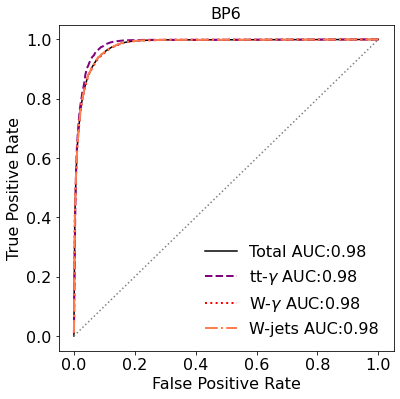

In [105]:
plt.figure(figsize=(6, 6))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.plot(fpr_total, tpr_total, c = 'black', label = 'Total AUC:{:.2f}'.format(auc_total))
plt.plot(fpr_ttgamma, tpr_ttgamma, c = ttgamma_color, linestyle = '--', lw = 2, label = 'tt-$\gamma$ AUC:{:.2f}'.format(auc_ttgamma))
plt.plot(fpr_wgamma, tpr_wgamma, c = wgamma_color, linestyle = ':', lw = 2, label = 'W-$\gamma$ AUC:{:.2f}'.format(auc_wgamma))
plt.plot(fpr_wjets, tpr_wjets, c = wjets_color, linestyle = '-.', lw = 2, label = 'W-jets AUC:{:.2f}'.format(auc_wjets))
plt.legend(frameon=False,fontsize=16)
plt.ylabel("True Positive Rate",fontsize=16)
plt.xlabel("False Positive Rate",fontsize=16)
plt.plot([0,1],[0,1],ls=":",color="grey")
plt.title(r"BP" + str(bp + 1),fontsize=16)

#plt.savefig('../graph/ROC_BP' + str(bp + 1) + '_All.png', bbox_inches='tight')

[Text(0, 0, 'lepton $p_T$ [GeV]'),
 Text(0, 1, '$S_T$ [GeV]'),
 Text(0, 2, '$m_T$ jet [GeV]'),
 Text(0, 3, 'photon $p_T$ [GeV]'),
 Text(0, 4, 'MET sig [GeV]'),
 Text(0, 5, 'num_taus'),
 Text(0, 6, 'lepton $\\phi$'),
 Text(0, 7, 'photon $\\phi$'),
 Text(0, 8, 'num photon'),
 Text(0, 9, 'photon $\\eta$'),
 Text(0, 10, 'MET $p_T$ [GeV]'),
 Text(0, 11, 'lepton $\\eta$'),
 Text(0, 12, '$H_T$ (jets) [GeV]'),
 Text(0, 13, 'MET $\\phi$'),
 Text(0, 14, 'num_jets'),
 Text(0, 15, 'jet $\\eta$'),
 Text(0, 16, 'num lepton'),
 Text(0, 17, '$H_T$ [GeV]'),
 Text(0, 18, 'jet $p_T$ [GeV]'),
 Text(0, 19, 'jet $\\phi$'),
 Text(0, 20, '$m_T$ photon [GeV]')]

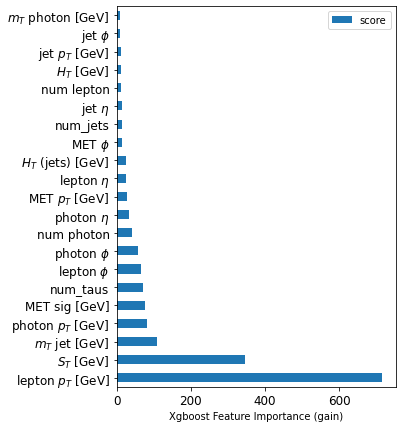

In [106]:
fig, ax = plt.subplots(figsize = (5,7))

feature_important = classifier.get_booster().get_score(importance_type='gain')
values = list(feature_important.values())

data = pd.DataFrame(data=values, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(len(lst) - 1, columns="score").plot(kind='barh', ax = ax) ## plot top 20 features

ax.set_xlabel("Xgboost Feature Importance (gain)")
ax.set_yticklabels(np.asarray(lst)[np.argsort(values)[::-1]])

#plt.savefig('../graph/BP' + str(bp + 1) + '_featureImportance_All.png', bbox_inches='tight')

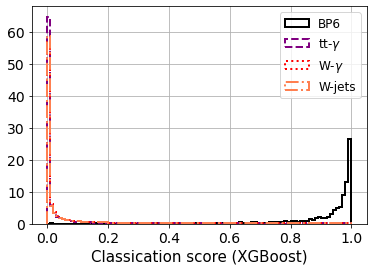

In [107]:
plt.hist(y_pred_xg[np.where(bkg_flag_test == 0)[0]], bins = 100, range=[0,1], histtype='step', density = True, color = 'black', label = 'BP' + str(bp + 1), lw = 2)
plt.hist(y_pred_xg[np.where(bkg_flag_test == 3)[0]], bins = 100, range=[0,1], histtype='step', density = True, color = ttgamma_color, linestyle = '--', lw = 2, label = 'tt-$\gamma$')
plt.hist(y_pred_xg[np.where(bkg_flag_test == 1)[0]], bins = 100, range=[0,1], histtype='step', density = True, color = wgamma_color, linestyle = ':', lw = 2, label = 'W-$\gamma$')
plt.hist(y_pred_xg[np.where(bkg_flag_test == 2)[0]], bins = 100, range=[0,1], histtype='step', density = True, color = wjets_color, linestyle = '-.', lw = 2, label = 'W-jets')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (XGBoost)",fontsize=15)
#plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)
#plt.savefig('../graph/MLOutput_dist_BP' + str(bp + 1) + '_All.png', bbox_inches="tight")

In [108]:
pred_XG_NP = y_pred_xg[np.where(bkg_flag_test == 0)[0]]
pred_XG_SM = y_pred_xg[np.where(bkg_flag_test != 0)[0]]

In [109]:
len(np.where(bkg_flag_test != 0)[0])

324225

In [110]:
len(np.where(bkg_flag_test == 0)[0])

3156

Text(0.5, 1.0, 'BP6')

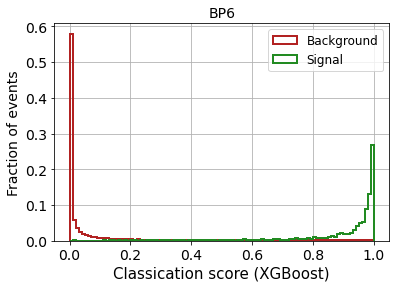

In [111]:
# XGBoost

########################
# CLASSIFICATION SCORE #
########################
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 100, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 100, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (XGBoost)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)
plt.title('BP' + str(bp + 1), fontsize=14)

#plt.savefig('../graph/' + '2monian-output.pdf', format="pdf", bbox_inches="tight")

In [112]:
S_expected[bp]

334.036999285

In [113]:
S_expected[bp] / np.sqrt(B_expected)

0.9587148678265914

In [114]:
print('MLL aproximated Z:')
print( MLL_aprox_discovery_ox(pred_XG_SM, pred_XG_NP, int(B_expected), int(S_expected[bp]))) 

MLL aproximated Z:
nan


/tmp/ipykernel_426940/1019789035.py:10: RuntimeWarning: invalid value encountered in double_scalars
  return (f0 + fB + fS)**0.5


## Sequential selection criteria

In [ ]:
nbins = 10
indices_aux = np.arange(len(df_test_array))
        
n_np0      = len(np.where(df_test_array[:, 22] == 0)[0])
n_wgamma0  = len(np.where(df_test_array[:, 22] == 1)[0])
n_wjets0   = len(np.where(df_test_array[:, 22] == 2)[0])
n_ttgamma0 = len(np.where(df_test_array[:, 22] == 3)[0])

sup_cuts = {}
inf_cuts = {}
random_vars = np.random.choice(range(len(df_test.columns) - 2), size = 50, replace = True)

for ivar in random_vars:
    #print(indices_aux)
    cuts = np.linspace(np.min(df_test_array[indices_aux,ivar]), np.max(df_test_array[indices_aux,ivar]), nbins)
    Z_sup = np.zeros(nbins)
    Z_inf = np.zeros(nbins)

    indices = []
    Z = []
    for icut, cut in enumerate(cuts): 
        
        # Superior ------------------------------------------------------------------------------------
        indices_sup = indices_aux[np.where( (df_test_array[indices_aux,ivar] >= cut) )[0]]
        indices.append(indices_sup)
        n_np      = len(np.where(df_test_array[indices_sup, 22] == 0)[0])
        n_wgamma  = len(np.where(df_test_array[indices_sup, 22] == 1)[0])
        n_wjets   = len(np.where(df_test_array[indices_sup, 22] == 2)[0])
        n_ttgamma = len(np.where(df_test_array[indices_sup, 22] == 3)[0])

        ttgamma_expected = ttgamma_cross * 1000 * ttgamma_NLO * luminosidad * (n_ttgamma * ttgamma_aceptancia_init / n_ttgamma0)
        wgamma_expected  = Wgamma_cross * 1000 * Wgamma_NLO * luminosidad * (n_wgamma * Wgamma_aceptancia_init / n_wgamma0)
        wjets_expected   = Wjets_cross * 1000 * Wjets_NLO * luminosidad * (n_wjets * Wjets_aceptancia_init / n_wjets0)


        S_expected_aux = int(cross[bp] * luminosidad * (n_np * aceptancia[bp] / n_np0))

        # Formula discovery
        B_expected_aux = int(ttgamma_expected + wgamma_expected + wjets_expected)
        #if B_expected > 5: Z_sup[icut] = np.sqrt(2 * ((B_expected + S_expected) * np.log(1 + S_expected / B_expected) - S_expected))
        if (B_expected_aux > 5) and (S_expected_aux > 5): 
            Z_sup[icut] = np.sqrt(2 * ((B_expected_aux + S_expected_aux) * np.log(1 + S_expected_aux / B_expected_aux) - S_expected_aux))
            Z.append( np.sqrt(2 * ((B_expected_aux + S_expected_aux) * np.log(1 + S_expected_aux / B_expected_aux) - S_expected_aux)) )
        else:
            Z.append(0)
        #----------------------------------------------------------------------------------------------------

        # Inferior ------------------------------------------------------------------------------------
        indices_inf = indices_aux[np.where( (df_test_array[indices_aux,ivar] <= cut) )[0]]
        indices.append(indices_inf)
        
        n_np      = len(np.where(df_test_array[indices_inf, 22] == 0)[0])
        n_wgamma  = len(np.where(df_test_array[indices_inf, 22] == 1)[0])
        n_wjets   = len(np.where(df_test_array[indices_inf, 22] == 2)[0])
        n_ttgamma = len(np.where(df_test_array[indices_inf, 22] == 3)[0])

        ttgamma_expected = ttgamma_cross * 1000 * ttgamma_NLO * luminosidad * (n_ttgamma * ttgamma_aceptancia_init / n_ttgamma0)
        wgamma_expected  = Wgamma_cross * 1000 * Wgamma_NLO * luminosidad * (n_wgamma * Wgamma_aceptancia_init / n_wgamma0)
        wjets_expected   = Wjets_cross * 1000 * Wjets_NLO * luminosidad * (n_wjets * Wjets_aceptancia_init / n_wjets0)

        S_expected_aux = int(cross[bp] * luminosidad * (n_np * aceptancia[bp] / n_np0))

        # Formula discovery
        B_expected_aux = int(ttgamma_expected + wgamma_expected + wjets_expected)
        #if B_expected > 5: Z_inf[icut] = np.sqrt(2 * ((B_expected + S_expected) * np.log(1 + S_expected / B_expected) - S_expected))
        if (B_expected_aux > 5) and (S_expected_aux > 5): 
            Z_inf[icut] = np.sqrt(2 * ((B_expected_aux + S_expected_aux) * np.log(1 + S_expected_aux / B_expected_aux) - S_expected_aux))
            Z.append( np.sqrt(2 * ((B_expected_aux + S_expected_aux) * np.log(1 + S_expected_aux / B_expected_aux) - S_expected_aux)) )
        else:
            Z.append(0)
        #----------------------------------------------------------------------------------------------------
    max_cut = np.argmax(np.asarray(Z))
    #print('Z = ' + str(Z[max_cut]))
    indices_aux = indices[max_cut]
    max_cut = np.argmax((Z_inf, Z_sup))
    if max_cut >= len(Z_inf):
        print(df_test.columns[ivar] + ' >= ' + str(cuts[max_cut - len(Z_sup)]) + '; Z = ' + str(Z_sup[max_cut - len(Z_inf)]))
    #%    indices_aux = indices_aux[np.where( (df_test_array[indices_aux,ivar] >= cuts[max_cut - len(Z_sup)]) )[0]]
        if df.columns[ivar] in inf_cuts.keys():
            inf_cuts[df_test.columns[ivar]] = cuts[max_cut - len(Z_sup)]
        inf_cuts.setdefault(df_test.columns[ivar], cuts[max_cut - len(Z_sup)])
        sup_cuts.setdefault(df_test.columns[ivar], 999999)
    else:
        print(df_test.columns[ivar] + ' <= ' + str(cuts[max_cut]) + '; Z = ' + str(Z_inf[max_cut]))
    #%    indices_aux = indices_aux[np.where( (df_array[indices_aux,ivar] <= cuts[max_cut]) )[0]]
        if df.columns[ivar] in sup_cuts.keys():
            sup_cuts[df_test.columns[ivar]] = cuts[max_cut]
        sup_cuts.setdefault(df_test.columns[ivar], cuts[max_cut])
        inf_cuts.setdefault(df_test.columns[ivar], -999999)   
    
    
n_np = len(np.where(df_test_array[indices_aux, 22] == 0)[0])

n_wgamma  = len(np.where(df_test_array[indices_aux, 22] == 1)[0])
n_wjets   = len(np.where(df_test_array[indices_aux, 22] == 2)[0])
n_ttgamma = len(np.where(df_test_array[indices_aux, 22] == 3)[0])

ttgamma_expected = ttgamma_cross * 1000 * ttgamma_NLO * luminosidad * (n_ttgamma * ttgamma_aceptancia_init / n_ttgamma0)
wgamma_expected  = Wgamma_cross * 1000 * Wgamma_NLO * luminosidad * (n_wgamma * Wgamma_aceptancia_init / n_wgamma0)
wjets_expected   = Wjets_cross * 1000 * Wjets_NLO * luminosidad * (n_wjets * Wjets_aceptancia_init / n_wjets0)

S_expected_aux = int(cross[bp] * luminosidad * (n_np * aceptancia[bp] / n_np0))

# Formula discovery
B_expected_aux = int(ttgamma_expected + wgamma_expected + wjets_expected)
if (B_expected_aux > 5) and (S_expected_aux > 5): 
    print('\n')
    print('Z = ', np.sqrt(2 * ((B_expected_aux + S_expected_aux) * np.log(1 + S_expected_aux / B_expected_aux) - S_expected_aux)))
    print('Expected Background = ' + str(B_expected_aux))
    print('Expected Signal = ' + str(S_expected_aux))

In [ ]:
sup_cuts

In [ ]:
inf_cuts

In [ ]:
write = False
if write:
    with open('../data/cuts/BP' + str(bp+1) + '_supCuts.txt', "w") as fp:
        json.dump(sup_cuts, fp)

    with open('../data/cuts/BP' + str(bp+1) + '_infCuts.txt', "w") as fp:
        json.dump(inf_cuts, fp)
else:
    with open('../data/cuts/BP' + str(bp+1) + '_supCuts.txt', "r") as fp:
        # Load the dictionary from the file
        sup_cuts = json.load(fp)
    with open('../data/cuts/BP' + str(bp+1) + '_infCuts.txt', "r") as fp:
        # Load the dictionary from the file
        inf_cuts = json.load(fp)

In [ ]:
indices_aux = np.arange(len(df_test_array))

variables = list(sup_cuts.keys())
for i in range(len(variables)):
    ind_var = np.where(df_test.columns == variables[i])[0][0]
    indices_aux = indices_aux[np.where( (df_test_array[indices_aux, ind_var] <= sup_cuts[variables[i]]) & 
                            (df_test_array[indices_aux, ind_var] > inf_cuts[variables[i]])
                           )[0]]


In [ ]:
n_np = len(np.where(df_test_array[indices_aux, 22] == 0)[0])

n_wgamma  = len(np.where(df_test_array[indices_aux, 22] == 1)[0])
n_wjets   = len(np.where(df_test_array[indices_aux, 22] == 2)[0])
n_ttgamma = len(np.where(df_test_array[indices_aux, 22] == 3)[0])

ttgamma_expected = ttgamma_cross * 1000 * ttgamma_NLO * luminosidad * (n_ttgamma * ttgamma_aceptancia_init / n_ttgamma0)
wgamma_expected  = Wgamma_cross * 1000 * Wgamma_NLO * luminosidad * (n_wgamma * Wgamma_aceptancia_init / n_wgamma0)
wjets_expected   = Wjets_cross * 1000 * Wjets_NLO * luminosidad * (n_wjets * Wjets_aceptancia_init / n_wjets0)

S_expected_aux = int(cross[bp] * luminosidad * (n_np * aceptancia[bp] / n_np0))

# Formula discovery
B_expected_aux = int(ttgamma_expected + wgamma_expected + wjets_expected)
if (B_expected_aux >= 5) and (S_expected_aux >= 5): 
    print('\n')
    print('Z = ', np.sqrt(2 * ((B_expected_aux + S_expected_aux) * np.log(1 + S_expected_aux / B_expected_aux) - S_expected_aux)))
    print('Expected Background = ' + str(B_expected_aux))
    print('Expected Signal = ' + str(S_expected_aux))

In [ ]:
nexperiments = 2000

SM_test_pool = np.where(df_test_array[:,23] == 0)[0]
NP_test_pool = np.where(df_test_array[:,23] == 1)[0]

q0_exp = np.zeros(nexperiments)
B_observed_exp = np.zeros(nexperiments)
S_observed_exp = np.zeros(nexperiments)
for nexp in tqdm(range(nexperiments)):
    # Let's create a pseudo-experiment
    SM_indices = np.random.choice(SM_test_pool, size = np.random.poisson(int(B_expected)), replace = False)
    NP_indices = np.random.choice(NP_test_pool, size = np.random.poisson(int(S_expected[bp])), replace = False)
    indices_aux = np.concatenate((NP_indices, SM_indices))

    #%print('At the beggining')
    #%print('\n')
    #%print('Total:' + str(len(indices_aux)))
    #%print('NP:' + str(len(np.where(df_test_array[indices_aux, 23] == 1)[0])))
    #%print('SM:' + str(len(np.where(df_test_array[indices_aux, 23] == 0)[0])))
    #%print('wgamma:' + str(len(np.where(df_test_array[indices_aux, 22] == 1)[0])))
    #%print('ttgamma:' + str(len(np.where(df_test_array[indices_aux, 22] == 3)[0])))
    #%print('wjets:' + str(len(np.where(df_test_array[indices_aux, 22] == 2)[0])))
    #%print('\n')
    # Let's make the cuts

    variables = list(sup_cuts.keys())
    for i in range(len(variables)):
        #print(variables[i] + '<=' + str(sup_cuts[variables[i]]))
        #print(variables[i] + '>=' + str(inf_cuts[variables[i]]))
        ind_var = np.where(df_test.columns == variables[i])[0][0]
        indices_aux = indices_aux[np.where( (df_test_array[indices_aux, ind_var] <= sup_cuts[variables[i]]) & 
                                (df_test_array[indices_aux, ind_var] > inf_cuts[variables[i]])
                               )[0]]

        #%print('Total:' + str(len(indices_aux)))
        #%print('NP:' + str(len(np.where(df_test_array[indices_aux, 23] == 1)[0])))
        #%print('SM:' + str(len(np.where(df_test_array[indices_aux, 23] == 0)[0])))
        #%print('wgamma:' + str(len(np.where(df_test_array[indices_aux, 22] == 1)[0])))
        #%print('ttgamma:' + str(len(np.where(df_test_array[indices_aux, 22] == 3)[0])))
        #%print('wjets:' + str(len(np.where(df_test_array[indices_aux, 22] == 2)[0])))
    # Let's calculate everything
    
    n_np = len(np.where(df_test_array[indices_aux, 22] == 0)[0])

    n_wgamma  = len(np.where(df_test_array[indices_aux, 22] == 1)[0])
    n_wjets   = len(np.where(df_test_array[indices_aux, 22] == 2)[0])
    n_ttgamma = len(np.where(df_test_array[indices_aux, 22] == 3)[0])

    #%print('At the end')
    #%print('\n')
    #%print('Total:' + str(len(indices_aux)))
    #%print('NP:' + str(len(np.where(df_test_array[indices_aux, 23] == 1)[0])))
    #%print('NP:' + str(len(np.where(df_test_array[indices_aux, 22] == 0)[0])))
    #%print('SM:' + str(len(np.where(df_test_array[indices_aux, 23] == 0)[0])))
    #%print('wgamma:' + str(len(np.where(df_test_array[indices_aux, 22] == 1)[0])))
    #%print('ttgamma:' + str(len(np.where(df_test_array[indices_aux, 22] == 3)[0])))
    #%print('wjets:' + str(len(np.where(df_test_array[indices_aux, 22] == 2)[0])))
    #%print('\n')

    #S_expected_aux = n_np
    S_observed_exp[nexp] = n_np

    # Formula discovery
    B_observed_exp[nexp] = n_ttgamma + n_wgamma + n_wjets
    
    N_observed = n_np + n_ttgamma + n_wgamma + n_wjets
    if (B_expected_aux >= 5) and (S_expected_aux > 5): 
        q0_exp[nexp] = -2 * N_observed * np.log(B_expected_aux / N_observed) -2 * (N_observed - B_expected_aux)
        #Z_exp[nexp] = np.sqrt(2 * ((B_expected_aux + S_expected_aux) * np.log(1 + S_expected_aux / B_expected_aux) - S_expected_aux))
        #%print('\n')
        #%print('Z = ', Z_exp[nexp])
        #%print('Expected Background = ' + str(B_expected_aux))
        #%print('Expected Signal = ' + str(S_expected_aux))
    else:
        q0_exp[nexp] = -99
        #print('Expected Background = ' + str(B_observed_exp))
        #print('Expected Signal = ' + str(S_observed_exp))
    #%print('------------------------------------------')
        

In [ ]:
plt.hist(S_observed_exp)

In [ ]:
print('Final results: for BP ' + str(bp+1) + '\n ')
print('Z = ' + str(np.sqrt(np.median(q0_exp))) + '; Z_std = ' + str(np.std(q0_exp) / (2 * np.sqrt(np.median(q0_exp)))))
print('B_exp = ' + str(np.mean(B_observed_exp)) + '; B_exp_std = ' + str(np.std(B_observed_exp)))
print('S_exp = ' + str(np.mean(S_observed_exp)) + '; S_exp_std = ' + str(np.std(S_observed_exp)))

## BinnedLikelihood

In [ ]:
print(pred_XG_SM.shape)
print(pred_XG_NP.shape)

In [ ]:
B_expected = int(B_expected)

In [ ]:
MIN_EVS = 5 # min number of background events that we allow per bin
range_dat = [[0,1]] # range of our data (between 0 and 1 if its the ML output)

bins_to_test=range(1,500) # number of bins we are testing to see if condition holds

# FIND THE NUMBER OF BINS:
num_bins = max_num_bins(pred_XG_SM, int(B_expected), range_dat, MIN_EVS, bins_to_test)

print('\n FOR BIN LIKELIHOOD WE ARE SETTING:')
print('min number of Background events allowed per bin: ', MIN_EVS)
print('number of bins we are going to use: ', num_bins)
print('range of our data: ', range_dat)

In [ ]:
# Z Poisson Bin Likelihood (Asimov data set)
D_or_E = 'discovery'
store_Z_asimov = []

Z_asimov = Z_BL_asimov(D_or_E, pred_XG_SM, pred_XG_NP, B_expected, int(S_expected[bp]), 25, range_dat, MIN_EVS, linear_bins=True) 
store_Z_asimov.append( Z_asimov )
    
    
print('\n FINAL RESULT for BP' + str(bp+1) + ':\n')
print(store_Z_asimov)

In [ ]:
# requested number of pseudo experiments
num_pseudo = 100

# OPTION 2 (mu_hat with more precision) (slower, not so bad for bin likelihood)
store_Z_BL = []

    
print('B_expected: ', B_expected)
print('S_expected: ', S_expected[bp])
print('')

#Z_BL = BL_test_fast(D_or_E, pred_XG_SM, pred_XG_NP, B_expected, int(S_expected[bp]), num_pseudo, 25, range_dat, MIN_EVS, linear_bins=True, path = '../graph/BP' + str(bp+1) + '/') 
Z_BL = BL_test_fast(D_or_E, pred_XG_SM, pred_XG_NP, B_expected, int(S_expected[bp]), num_pseudo, 25, range_dat, MIN_EVS, linear_bins=True) 

store_Z_BL.append( list(Z_BL) )

print('muhat mean: ', Z_BL[2])
print('Z_bins: ', Z_BL[0])
print('std Z_bins: ', Z_BL[1])
print('Z_bins mu=0: ', Z_BL[3])
print('std Z_bins mu=0: ', Z_BL[4])
print('')
print('--------\n')
    
    
    
print('\n FINAL RESULT:\n')
print(store_Z_BL)

In [ ]:
# requested number of pseudo experiments
num_pseudo = 100

# OPTION 2 (mu_hat with more precision) (slower, not so bad for bin likelihood)
store_Z_BL = []

    
print('B_expected: ', B_expected)
print('S_expected: ', S_expected[bp])
print('')

#Z_BL = BL_test_fsolve(D_or_E, pred_XG_SM, pred_XG_NP, B_expected, int(S_expected[bp]), num_pseudo, 25, range_dat, MIN_EVS, linear_bins=True, path = '../graph/BP' + str(bp+1) + '/') 
Z_BL = BL_test_fsolve(D_or_E, pred_XG_SM, pred_XG_NP, B_expected, int(S_expected[bp]), num_pseudo, 25, range_dat, MIN_EVS, linear_bins=True) 

store_Z_BL.append( list(Z_BL) )

print('muhat mean: ', Z_BL[2])
print('Z_bins: ', Z_BL[0])
print('std Z_bins: ', Z_BL[1])
print('Z_bins mu=0: ', Z_BL[3])
print('std Z_bins mu=0: ', Z_BL[4])
print('')
print('--------\n')
    
    
    
print('\n FINAL RESULT:\n')
print(store_Z_BL)

## loop pseudo exps. Fix ML and KDE

/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf 10141.98617373  9640.74296072
  9066.99442428  8431.3671577   7721.35111155  6936.25838446
  6074.74886898  5136.05860809  4124.2247082   3027.31093564
  1849.56276265   602.45175737  -705.21142941 -1991.45603429]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [         -inf          -inf          -inf          -inf          -inf
          -inf          -inf          -inf         

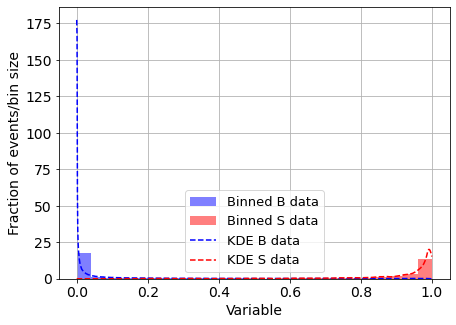

KDE Kernel:  epanechnikov
Background bandwidth:  0.0019008479046983867
Signal bandwidth:  0.013538761800225447


In [66]:
# USE KDE TO ESTIMATE THE CLASSIFIER OUTPUT PDFs

# outputs:
# 1st -> background PDF
# 2nd -> signal PDF
# 3rd -> (normalization factor of the background PDF)**-1
# 4th -> (normalization factor of the signal PDF)**-1
# 5th -> background bandwidth
# 6th -> signal bandwidth
kde_bkg, kde_sig, norm_factor_SM, norm_factor_NP, B_bandwidth, S_bandwidth = KDE_fitter(pred_XG_SM, pred_XG_NP, 
                                                                                        20000, # Numero de datos para fitear
                                                                                        np.logspace(-4.0, 0.05, 20), 
                                                                                        set_kernel='epanechnikov')

In [67]:
print(norm_factor_SM)
print(norm_factor_NP)

401.8536552905651
57.86191086281724


In [68]:
# we need to evaluate the KDE densities with the classifier output of BACKGROUND EVENTS

print('This may take a while...')

pB_B_data = np.exp(kde_bkg.score_samples(np.c_[pred_XG_SM, np.zeros(len(pred_XG_SM)) ]) )
print('1 done')
pS_B_data = np.exp(kde_sig.score_samples(np.c_[pred_XG_SM, np.ones(len(pred_XG_SM)) ]) )
print('2 done')

# Normalize
pB_B_data = pB_B_data / norm_factor_SM
pS_B_data = pS_B_data / norm_factor_NP

This may take a while...
1 done
2 done


In [69]:
# FOR DISCOVERY:
# we need to evaluate the KDE densities with the classifier output of BACKGROUND and SIGNAL EVENTS

pB_S_data = np.exp(kde_bkg.score_samples(np.c_[pred_XG_NP, np.zeros(len(pred_XG_NP)) ]) )
print('3 done')
pS_S_data = np.exp(kde_sig.score_samples(np.c_[pred_XG_NP, np.ones(len(pred_XG_NP)) ]) )
print('4 done')

# Normalize
pB_S_data = pB_S_data / norm_factor_SM
pS_S_data = pS_S_data / norm_factor_NP
   

3 done
4 done


(array([907., 350., 179., 181., 148., 124., 103., 262., 317., 585.]),
 array([ 0.03544973,  2.04669226,  4.05793479,  6.06917732,  8.08041985,
        10.09166238, 12.10290491, 14.11414744, 16.12538997, 18.1366325 ,
        20.14787503]),
 [<matplotlib.patches.Polygon at 0x7f5d65757310>])

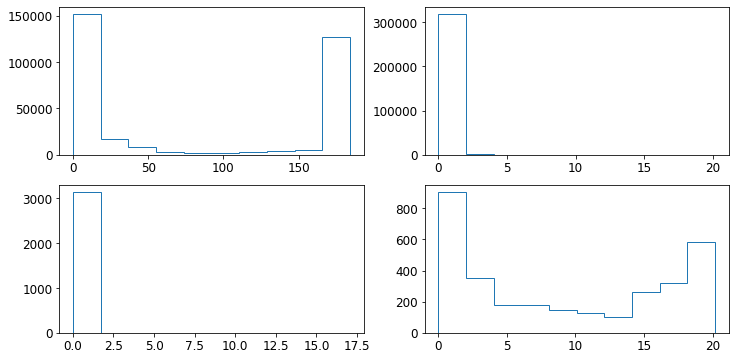

In [70]:
fig,ax = plt.subplots(2,2, figsize = (12,6))

ax[0,0].hist(pB_B_data, histtype = 'step')
ax[0,1].hist(pS_B_data, histtype = 'step')

ax[1,0].hist(pB_S_data, histtype = 'step')
ax[1,1].hist(pS_S_data, histtype = 'step')

In [71]:
# indeces (to later build a random pseudo experiment)
indices_B = [i for i in range(len(pS_B_data))]
indices_S = [i for i in range(len(pS_S_data))]
        
        

In [74]:
# loop over the number of pseudo experiments
#np.random.seed(91218)
Z_MLL = []
Z_MLL_std = []
Z_MLL_mu = []
Z_MLL_std_mu = []
for iloop in range(20): 
    print(iloop)
    muhat_selected_MLL_list = []
    q_muhat_MLL = []
    q_muhat_MLL_mu = []
    for its in tqdm(range(200)):

        # this pseudo-exp has B_rand number of B events
        B_rand = np.random.poisson(int(B_expected))

        ran_ind = np.random.choice(indices_B, B_rand)

        pB_B_data_shuf = []
        pS_B_data_shuf = []

        # for each event x_i in the pseudo, save pb(o(x_i)) and ps(o(x_i)) (notice its the same x_i for pb and ps)
        for i in ran_ind:
            pB_B_data_shuf.append(pB_B_data[i])
            pS_B_data_shuf.append(pS_B_data[i])

        pB_B_data_shuf  = np.array(pB_B_data_shuf)
        pS_B_data_shuf  = np.array(pS_B_data_shuf)



        # this pseudo-exp has S_rand number of S events
        S_rand = np.random.poisson(int(S_expected[bp]))

        ran_ind = np.random.choice(indices_S, S_rand)

        pB_S_data_shuf = []
        pS_S_data_shuf = []

        # for each event x_i in the pseudo, save pb(o(x_i)) and ps(o(x_i)) (notice its the same x_i for pb and ps)
        for i in ran_ind:
            pB_S_data_shuf.append(pB_S_data[i])
            pS_S_data_shuf.append(pS_S_data[i])

        pB_S_data_shuf  = np.array(pB_S_data_shuf)
        pS_S_data_shuf  = np.array(pS_S_data_shuf)

        # p_b(o(x_ensemble)) =  concatenate: p_b(o(B_ensemble)) and p_b(o(S_ensemble)) 
        prob_x_given_B = np.concatenate([pB_B_data_shuf,pB_S_data_shuf])

        # p_s(o(x_ensemble)) =  concatenate: p_s(o(B_ensemble)) and p_s(o(S_ensemble)) 
        prob_x_given_S = np.concatenate([pS_B_data_shuf,pS_S_data_shuf])



        # NOW WE HAVE p_{s,b}(x_ensemble) for this particular pseudo_experiment

        # approximation: mu_hat=1 (discovery)
        q_muhat_MLL_mu.append( 2 * ( ( -1. * int(S_expected[bp])) + sum( [np.log( 1 + ( (1.*int(S_expected[bp])/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )



        # ESTIMATE mu_hat for this particular ensemble (implicit equation)
        B_prob_x_given_B = [x * B_expected for x in prob_x_given_B]

        # reference points
        sum_muhat_zero = sum ( [(x*1.) / ( (x * (0) * int(S_expected[bp])) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )
        sum_muhat_two = sum ( [(x*1.) / ( (x * 2. * int(S_expected[bp])) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )


        # we need (implicit eq. for mu_hat) = 1
        # conditions considering the reference points
        if (sum_muhat_zero < sum_muhat_two < 1) or (1 < sum_muhat_two < sum_muhat_zero):
            print('muhat = 2.1')
            muhat_selected_MLL = 2.1

            print(r'<p_{b}(Sdata)> = ' + str(np.mean(pB_S_data_shuf)))
            print(r'<p_{s}(Sdata)> = ' + str(np.mean(pS_S_data_shuf)))
            print(r'<p_{b}(Bdata)> = ' + str(np.mean(pB_B_data_shuf)))
            print(r'<p_{s}(Bdata)> = ' + str(np.mean(pS_B_data_shuf)))

        elif (sum_muhat_two < sum_muhat_zero < 1) or (1 < sum_muhat_zero < sum_muhat_two):
            print('muhat = -0.1')
            muhat_selected_MLL = -0.1

            print(r'<p_{b}(Sdata)> = ' + str(np.mean(pB_S_data_shuf)))
            print(r'<p_{s}(Sdata)> = ' + str(np.mean(pS_S_data_shuf)))
            print(r'<p_{b}(Bdata)> = ' + str(np.mean(pB_B_data_shuf)))
            print(r'<p_{s}(Bdata)> = ' + str(np.mean(pS_B_data_shuf)))

        elif sum_muhat_zero < 1 < sum_muhat_two:
            #print('muhat ~ 1')

            # grid, mu_hat is around 1
            muhat_test = np.arange(0, 2., 0.05)

            for vv in range(len(muhat_test)):

                mu_hat_condition_equal_1 = sum ( [(x*1.) / ( (x * muhat_test[vv] * int(S_expected[bp])) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

                if mu_hat_condition_equal_1 > 1:
                    muhat_selected_MLL = muhat_test[vv]
                    break

        elif sum_muhat_two < 1 < sum_muhat_zero:
            #print('muhat ~ 1')

            # grid, mu_hat is around 1
            muhat_test = np.arange(0, 2., 0.05)

            for vv in range(len(muhat_test)):

                mu_hat_condition_equal_1 = sum ( [(x*1.) / ( (x * muhat_test[vv] * int(S_expected[bp])) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

                if mu_hat_condition_equal_1 < 1:
                    muhat_selected_MLL = muhat_test[vv]
                    break


        # save the computed mu_hat (within range) for each pseudo_experiment
        muhat_selected_MLL_list.append(muhat_selected_MLL)


        # compute the test statistic for each pseudo_exp considering mu_hat
        if muhat_selected_MLL > 0:
            q_muhat_MLL.append( 2 * ( (-1.*muhat_selected_MLL * int(S_expected[bp])) + sum( [np.log( 1 + ( (muhat_selected_MLL*int(S_expected[bp])/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )

        else:
            q_muhat_MLL.append( 0 )
            
    

    # With the calculation of mu_hat
    muhat_mean_MLL = np.mean(muhat_selected_MLL_list)
    Z_MLL_aux = abs( np.median(q_muhat_MLL) )**0.5
    Z_MLL.append( Z_MLL_aux )
    Z_MLL_std.append( np.std(q_muhat_MLL) / (2.*Z_MLL_aux) )


    # With the approximation of mu_hat
    Z_MLL_mu_aux = abs( np.median(q_muhat_MLL_mu) )**0.5
    Z_MLL_mu.append( Z_MLL_mu_aux )
    Z_MLL_std_mu.append( np.std(q_muhat_MLL_mu) / (2.*Z_MLL_mu_aux) )

0


100%|██████████████████████████████████████████████████████████████████| 200/200 [04:05<00:00,  1.23s/it]


1


100%|██████████████████████████████████████████████████████████████████| 200/200 [04:00<00:00,  1.20s/it]


2


100%|██████████████████████████████████████████████████████████████████| 200/200 [03:56<00:00,  1.18s/it]


3


100%|██████████████████████████████████████████████████████████████████| 200/200 [04:01<00:00,  1.21s/it]


4


100%|██████████████████████████████████████████████████████████████████| 200/200 [04:02<00:00,  1.21s/it]


5


100%|██████████████████████████████████████████████████████████████████| 200/200 [03:57<00:00,  1.19s/it]


6


100%|██████████████████████████████████████████████████████████████████| 200/200 [04:00<00:00,  1.20s/it]


7


100%|██████████████████████████████████████████████████████████████████| 200/200 [03:59<00:00,  1.20s/it]


8


100%|██████████████████████████████████████████████████████████████████| 200/200 [03:43<00:00,  1.12s/it]


9


100%|██████████████████████████████████████████████████████████████████| 200/200 [03:49<00:00,  1.15s/it]


10


100%|██████████████████████████████████████████████████████████████████| 200/200 [03:47<00:00,  1.14s/it]


11


100%|██████████████████████████████████████████████████████████████████| 200/200 [03:54<00:00,  1.17s/it]


12


100%|██████████████████████████████████████████████████████████████████| 200/200 [03:53<00:00,  1.17s/it]


13


100%|██████████████████████████████████████████████████████████████████| 200/200 [03:51<00:00,  1.16s/it]


14


100%|██████████████████████████████████████████████████████████████████| 200/200 [03:42<00:00,  1.11s/it]


15


100%|██████████████████████████████████████████████████████████████████| 200/200 [03:49<00:00,  1.15s/it]


16


100%|██████████████████████████████████████████████████████████████████| 200/200 [03:49<00:00,  1.15s/it]


17


100%|██████████████████████████████████████████████████████████████████| 200/200 [03:47<00:00,  1.14s/it]


18


100%|██████████████████████████████████████████████████████████████████| 200/200 [03:49<00:00,  1.15s/it]


19


100%|██████████████████████████████████████████████████████████████████| 200/200 [03:45<00:00,  1.13s/it]


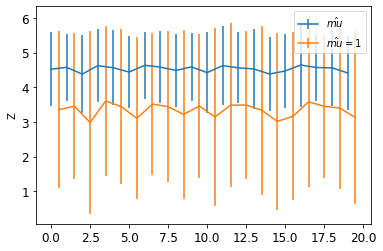

In [80]:
#plt.scatter(np.arange(len(Z_MLL)), np.asarray(Z_MLL))
plt.errorbar(np.arange(len(Z_MLL)), np.asarray(Z_MLL), np.asarray(Z_MLL_std), label = '$\hat{mu}$')
plt.errorbar(np.arange(len(Z_MLL_mu)) + 0.5, np.asarray(Z_MLL_mu), np.asarray(Z_MLL_std_mu), label =  '$\hat{mu} = 1$')
#plt.scatter(np.arange(len(Z_MLL)), np.asarray(Z_MLL_mu))
plt.legend()
plt.ylabel('Z')
plt.savefig('../graph/loopBP6_KDEfijo.pdf')

## Loop varying KDE

In [76]:
B_expected

121397

0


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
 27634.30231933 26630.69736544 25476.82767159 24180.30270989
 22705.96760693 21075.67635274 19276.52871534 17304.99476317
 15156.43838821 12817.96080023 10276.49455308  7543.53255738
  4606.88305894  1493.35355545 -1729.77795877 -4960.29262449]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [         -inf          -inf          -inf          -inf          -inf
          -inf          -inf          -inf         

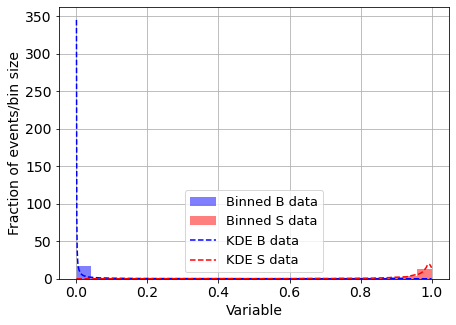

KDE Kernel:  epanechnikov
Background bandwidth:  0.0007122485584859914
Signal bandwidth:  0.013538761800225447
This may take a while...
1 done
2 done
3 done
4 done


100%|███████████████████████████████████| 50/50 [01:43<00:00,  2.08s/it]


1


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
 27634.30231933 26630.69736544 25476.82767159 24180.30270989
 22705.96760693 21075.67635274 19276.52871534 17304.99476317
 15156.43838821 12817.96080023 10276.49455308  7543.53255738
  4606.88305894  1493.35355545 -1729.77795877 -4960.29262449]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [         -inf          -inf          -inf          -inf          -inf
          -inf          -inf          -inf         

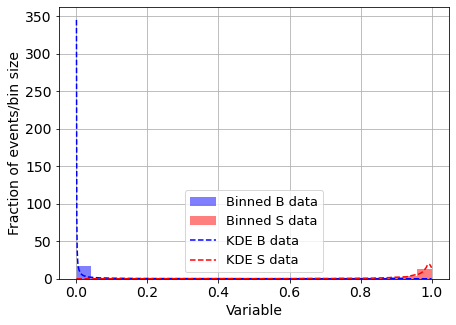

KDE Kernel:  epanechnikov
Background bandwidth:  0.0007122485584859914
Signal bandwidth:  0.013538761800225447
This may take a while...
1 done
2 done
3 done
4 done


100%|███████████████████████████████████| 50/50 [01:40<00:00,  2.00s/it]


2


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
 27634.30231933 26630.69736544 25476.82767159 24180.30270989
 22705.96760693 21075.67635274 19276.52871534 17304.99476317
 15156.43838821 12817.96080023 10276.49455308  7543.53255738
  4606.88305894  1493.35355545 -1729.77795877 -4960.29262449]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [         -inf          -inf          -inf          -inf          -inf
          -inf          -inf          -inf         

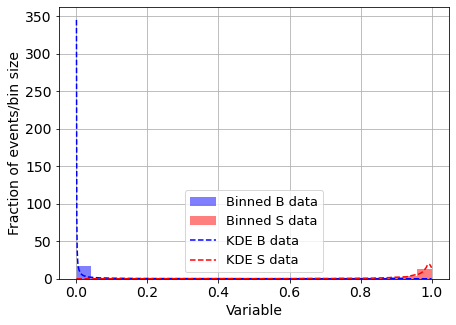

KDE Kernel:  epanechnikov
Background bandwidth:  0.0007122485584859914
Signal bandwidth:  0.013538761800225447
This may take a while...
1 done
2 done
3 done
4 done


100%|███████████████████████████████████| 50/50 [01:40<00:00,  2.02s/it]


3


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
 27634.30231933 26630.69736544 25476.82767159 24180.30270989
 22705.96760693 21075.67635274 19276.52871534 17304.99476317
 15156.43838821 12817.96080023 10276.49455308  7543.53255738
  4606.88305894  1493.35355545 -1729.77795877 -4960.29262449]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [         -inf          -inf          -inf          -inf          -inf
          -inf          -inf          -inf         

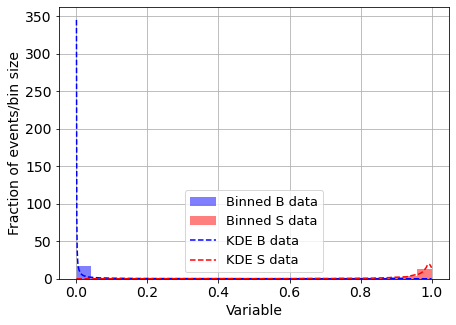

KDE Kernel:  epanechnikov
Background bandwidth:  0.0007122485584859914
Signal bandwidth:  0.013538761800225447
This may take a while...
1 done
2 done
3 done
4 done


100%|███████████████████████████████████| 50/50 [01:32<00:00,  1.85s/it]


4


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
 27634.30231933 26630.69736544 25476.82767159 24180.30270989
 22705.96760693 21075.67635274 19276.52871534 17304.99476317
 15156.43838821 12817.96080023 10276.49455308  7543.53255738
  4606.88305894  1493.35355545 -1729.77795877 -4960.29262449]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [         -inf          -inf          -inf          -inf          -inf
          -inf          -inf          -inf         

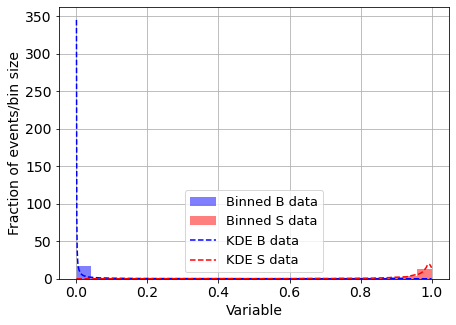

KDE Kernel:  epanechnikov
Background bandwidth:  0.0007122485584859914
Signal bandwidth:  0.013538761800225447
This may take a while...
1 done
2 done
3 done
4 done


100%|███████████████████████████████████| 50/50 [01:35<00:00,  1.91s/it]


5


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
 27634.30231933 26630.69736544 25476.82767159 24180.30270989
 22705.96760693 21075.67635274 19276.52871534 17304.99476317
 15156.43838821 12817.96080023 10276.49455308  7543.53255738
  4606.88305894  1493.35355545 -1729.77795877 -4960.29262449]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [         -inf          -inf          -inf          -inf          -inf
          -inf          -inf          -inf         

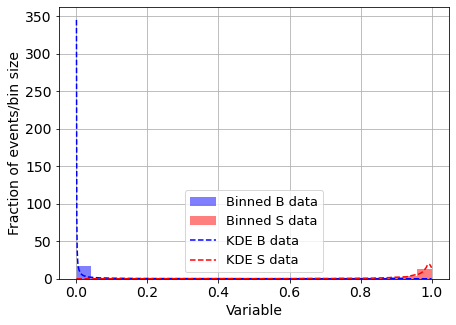

KDE Kernel:  epanechnikov
Background bandwidth:  0.0007122485584859914
Signal bandwidth:  0.013538761800225447
This may take a while...
1 done
2 done
3 done
4 done


100%|███████████████████████████████████| 50/50 [01:35<00:00,  1.91s/it]


6


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
 27634.30231933 26630.69736544 25476.82767159 24180.30270989
 22705.96760693 21075.67635274 19276.52871534 17304.99476317
 15156.43838821 12817.96080023 10276.49455308  7543.53255738
  4606.88305894  1493.35355545 -1729.77795877 -4960.29262449]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [         -inf          -inf          -inf          -inf          -inf
          -inf          -inf          -inf         

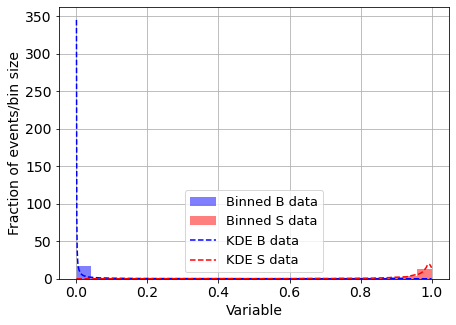

KDE Kernel:  epanechnikov
Background bandwidth:  0.0007122485584859914
Signal bandwidth:  0.013538761800225447
This may take a while...
1 done
2 done
3 done
4 done


100%|███████████████████████████████████| 50/50 [01:32<00:00,  1.86s/it]


7


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
 27634.30231933 26630.69736544 25476.82767159 24180.30270989
 22705.96760693 21075.67635274 19276.52871534 17304.99476317
 15156.43838821 12817.96080023 10276.49455308  7543.53255738
  4606.88305894  1493.35355545 -1729.77795877 -4960.29262449]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [         -inf          -inf          -inf          -inf          -inf
          -inf          -inf          -inf         

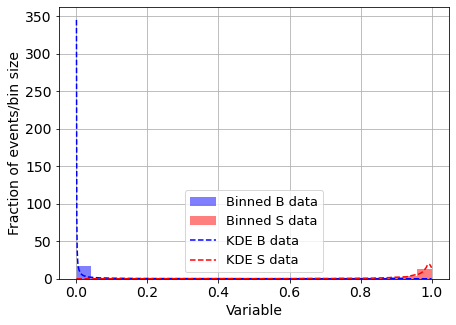

KDE Kernel:  epanechnikov
Background bandwidth:  0.0007122485584859914
Signal bandwidth:  0.013538761800225447
This may take a while...
1 done
2 done
3 done
4 done


100%|███████████████████████████████████| 50/50 [01:35<00:00,  1.90s/it]


8


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
 27634.30231933 26630.69736544 25476.82767159 24180.30270989
 22705.96760693 21075.67635274 19276.52871534 17304.99476317
 15156.43838821 12817.96080023 10276.49455308  7543.53255738
  4606.88305894  1493.35355545 -1729.77795877 -4960.29262449]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [         -inf          -inf          -inf          -inf          -inf
          -inf          -inf          -inf         

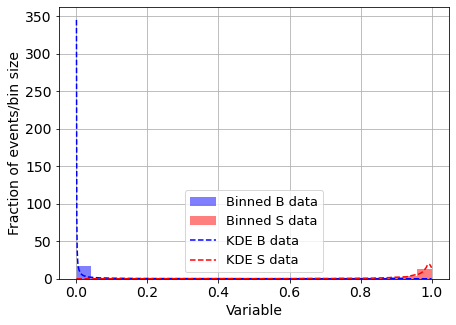

KDE Kernel:  epanechnikov
Background bandwidth:  0.0007122485584859914
Signal bandwidth:  0.013538761800225447
This may take a while...
1 done
2 done
3 done
4 done


100%|███████████████████████████████████| 50/50 [01:33<00:00,  1.87s/it]


9


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
 27634.30231933 26630.69736544 25476.82767159 24180.30270989
 22705.96760693 21075.67635274 19276.52871534 17304.99476317
 15156.43838821 12817.96080023 10276.49455308  7543.53255738
  4606.88305894  1493.35355545 -1729.77795877 -4960.29262449]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [         -inf          -inf          -inf          -inf          -inf
          -inf          -inf          -inf         

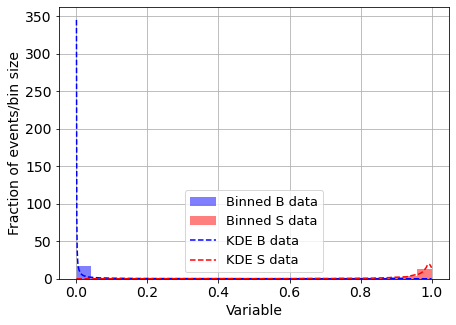

KDE Kernel:  epanechnikov
Background bandwidth:  0.0007122485584859914
Signal bandwidth:  0.013538761800225447
This may take a while...
1 done
2 done
3 done
4 done


100%|███████████████████████████████████| 50/50 [01:37<00:00,  1.95s/it]


10


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
 27634.30231933 26630.69736544 25476.82767159 24180.30270989
 22705.96760693 21075.67635274 19276.52871534 17304.99476317
 15156.43838821 12817.96080023 10276.49455308  7543.53255738
  4606.88305894  1493.35355545 -1729.77795877 -4960.29262449]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [         -inf          -inf          -inf          -inf          -inf
          -inf          -inf          -inf         

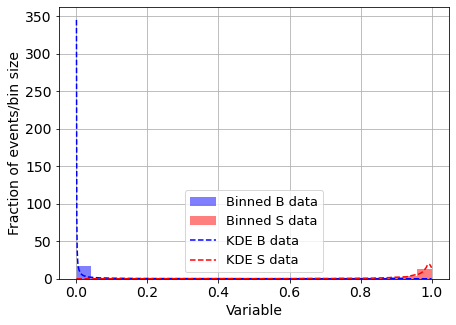

KDE Kernel:  epanechnikov
Background bandwidth:  0.0007122485584859914
Signal bandwidth:  0.013538761800225447
This may take a while...
1 done
2 done
3 done
4 done


100%|███████████████████████████████████| 50/50 [01:33<00:00,  1.86s/it]


11


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
 27634.30231933 26630.69736544 25476.82767159 24180.30270989
 22705.96760693 21075.67635274 19276.52871534 17304.99476317
 15156.43838821 12817.96080023 10276.49455308  7543.53255738
  4606.88305894  1493.35355545 -1729.77795877 -4960.29262449]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [         -inf          -inf          -inf          -inf          -inf
          -inf          -inf          -inf         

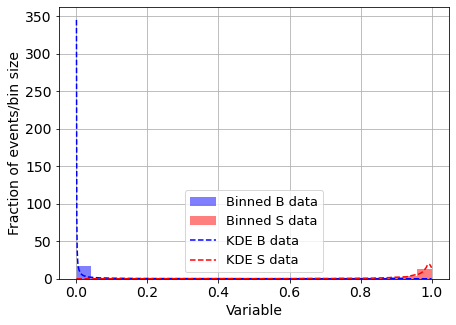

KDE Kernel:  epanechnikov
Background bandwidth:  0.0007122485584859914
Signal bandwidth:  0.013538761800225447
This may take a while...
1 done
2 done
3 done
4 done


100%|███████████████████████████████████| 50/50 [01:32<00:00,  1.86s/it]


12


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
 27634.30231933 26630.69736544 25476.82767159 24180.30270989
 22705.96760693 21075.67635274 19276.52871534 17304.99476317
 15156.43838821 12817.96080023 10276.49455308  7543.53255738
  4606.88305894  1493.35355545 -1729.77795877 -4960.29262449]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [         -inf          -inf          -inf          -inf          -inf
          -inf          -inf          -inf         

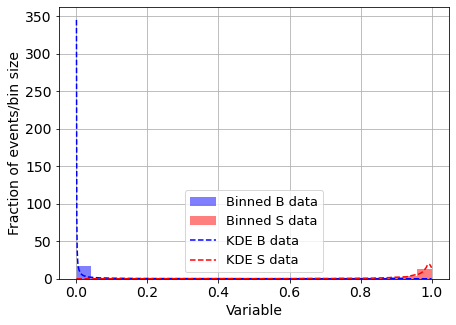

KDE Kernel:  epanechnikov
Background bandwidth:  0.0007122485584859914
Signal bandwidth:  0.013538761800225447
This may take a while...
1 done
2 done
3 done
4 done


100%|███████████████████████████████████| 50/50 [01:34<00:00,  1.90s/it]


13


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
 27634.30231933 26630.69736544 25476.82767159 24180.30270989
 22705.96760693 21075.67635274 19276.52871534 17304.99476317
 15156.43838821 12817.96080023 10276.49455308  7543.53255738
  4606.88305894  1493.35355545 -1729.77795877 -4960.29262449]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [         -inf          -inf          -inf          -inf          -inf
          -inf          -inf          -inf         

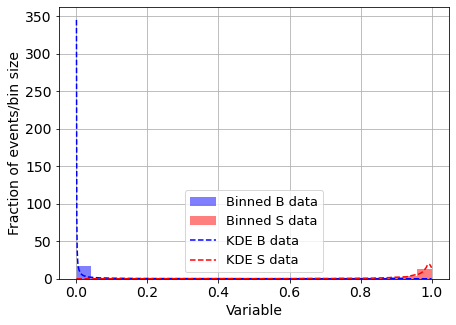

KDE Kernel:  epanechnikov
Background bandwidth:  0.0007122485584859914
Signal bandwidth:  0.013538761800225447
This may take a while...
1 done
2 done
3 done
4 done


100%|███████████████████████████████████| 50/50 [01:34<00:00,  1.88s/it]


14


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
 27634.30231933 26630.69736544 25476.82767159 24180.30270989
 22705.96760693 21075.67635274 19276.52871534 17304.99476317
 15156.43838821 12817.96080023 10276.49455308  7543.53255738
  4606.88305894  1493.35355545 -1729.77795877 -4960.29262449]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [         -inf          -inf          -inf          -inf          -inf
          -inf          -inf          -inf         

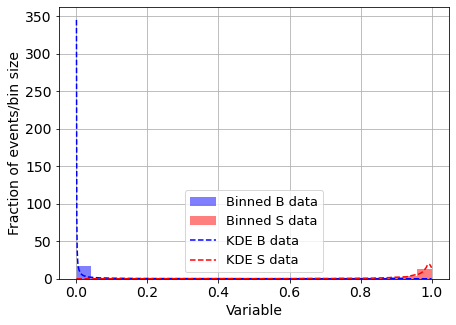

KDE Kernel:  epanechnikov
Background bandwidth:  0.0007122485584859914
Signal bandwidth:  0.013538761800225447
This may take a while...
1 done
2 done
3 done
4 done


100%|███████████████████████████████████| 50/50 [01:33<00:00,  1.88s/it]


15


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
 27634.30231933 26630.69736544 25476.82767159 24180.30270989
 22705.96760693 21075.67635274 19276.52871534 17304.99476317
 15156.43838821 12817.96080023 10276.49455308  7543.53255738
  4606.88305894  1493.35355545 -1729.77795877 -4960.29262449]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [         -inf          -inf          -inf          -inf          -inf
          -inf          -inf          -inf         

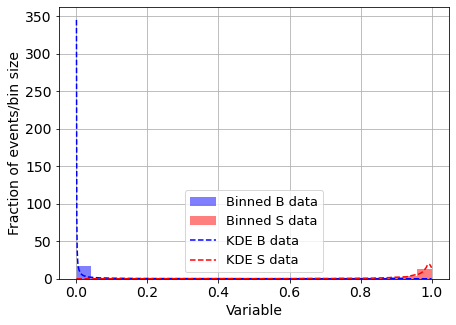

KDE Kernel:  epanechnikov
Background bandwidth:  0.0007122485584859914
Signal bandwidth:  0.013538761800225447
This may take a while...
1 done
2 done
3 done
4 done


100%|███████████████████████████████████| 50/50 [01:35<00:00,  1.91s/it]


16


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
 27634.30231933 26630.69736544 25476.82767159 24180.30270989
 22705.96760693 21075.67635274 19276.52871534 17304.99476317
 15156.43838821 12817.96080023 10276.49455308  7543.53255738
  4606.88305894  1493.35355545 -1729.77795877 -4960.29262449]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [         -inf          -inf          -inf          -inf          -inf
          -inf          -inf          -inf         

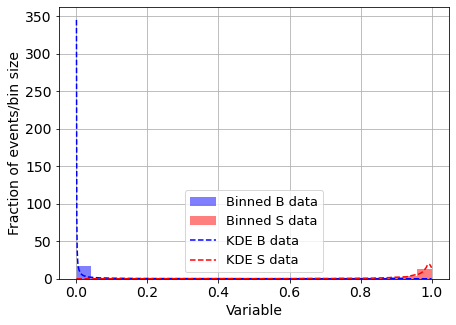

KDE Kernel:  epanechnikov
Background bandwidth:  0.0007122485584859914
Signal bandwidth:  0.013538761800225447
This may take a while...
1 done
2 done
3 done
4 done


100%|███████████████████████████████████| 50/50 [01:32<00:00,  1.85s/it]


17


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
 27634.30231933 26630.69736544 25476.82767159 24180.30270989
 22705.96760693 21075.67635274 19276.52871534 17304.99476317
 15156.43838821 12817.96080023 10276.49455308  7543.53255738
  4606.88305894  1493.35355545 -1729.77795877 -4960.29262449]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [         -inf          -inf          -inf          -inf          -inf
          -inf          -inf          -inf         

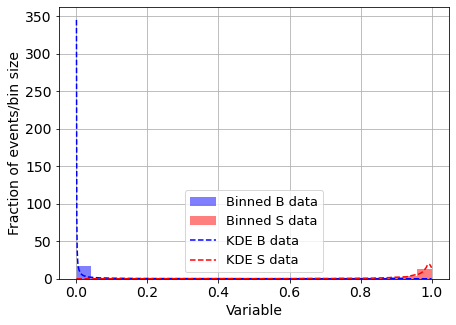

KDE Kernel:  epanechnikov
Background bandwidth:  0.0007122485584859914
Signal bandwidth:  0.013538761800225447
This may take a while...
1 done
2 done
3 done
4 done


100%|███████████████████████████████████| 50/50 [01:34<00:00,  1.90s/it]


18


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
 27634.30231933 26630.69736544 25476.82767159 24180.30270989
 22705.96760693 21075.67635274 19276.52871534 17304.99476317
 15156.43838821 12817.96080023 10276.49455308  7543.53255738
  4606.88305894  1493.35355545 -1729.77795877 -4960.29262449]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [         -inf          -inf          -inf          -inf          -inf
          -inf          -inf          -inf         

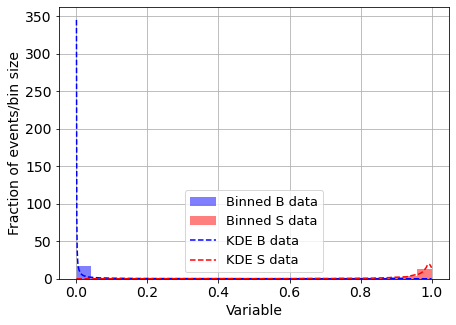

KDE Kernel:  epanechnikov
Background bandwidth:  0.0007122485584859914
Signal bandwidth:  0.013538761800225447
This may take a while...
1 done
2 done
3 done
4 done


100%|███████████████████████████████████| 50/50 [01:34<00:00,  1.89s/it]


19


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
 27634.30231933 26630.69736544 25476.82767159 24180.30270989
 22705.96760693 21075.67635274 19276.52871534 17304.99476317
 15156.43838821 12817.96080023 10276.49455308  7543.53255738
  4606.88305894  1493.35355545 -1729.77795877 -4960.29262449]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [         -inf          -inf          -inf          -inf          -inf
          -inf          -inf          -inf         

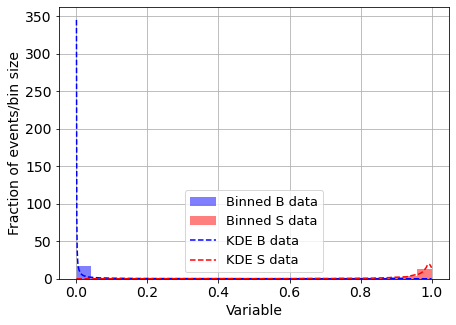

KDE Kernel:  epanechnikov
Background bandwidth:  0.0007122485584859914
Signal bandwidth:  0.013538761800225447
This may take a while...
1 done
2 done
3 done
4 done


100%|███████████████████████████████████| 50/50 [01:34<00:00,  1.90s/it]


In [115]:
Z_MLL = []
Z_MLL_std = []
Z_MLL_mu = []
Z_MLL_std_mu = []
for iloop in range(20):
    print(iloop)
    kde_bkg, kde_sig, norm_factor_SM, norm_factor_NP, B_bandwidth, S_bandwidth = KDE_fitter(pred_XG_SM, pred_XG_NP, 
                                                                                            50000, # Numero de datos para fitear
                                                                                            np.logspace(-4.0, 0.05, 20), 
                                                                                            set_kernel='epanechnikov')
    print('This may take a while...')

    pB_B_data = np.exp(kde_bkg.score_samples(np.c_[pred_XG_SM, np.zeros(len(pred_XG_SM)) ]) )
    print('1 done')
    pS_B_data = np.exp(kde_sig.score_samples(np.c_[pred_XG_SM, np.ones(len(pred_XG_SM)) ]) )
    print('2 done')

    # Normalize
    pB_B_data = pB_B_data / norm_factor_SM
    pS_B_data = pS_B_data / norm_factor_NP
    
    pB_S_data = np.exp(kde_bkg.score_samples(np.c_[pred_XG_NP, np.zeros(len(pred_XG_NP)) ]) )
    print('3 done')
    pS_S_data = np.exp(kde_sig.score_samples(np.c_[pred_XG_NP, np.ones(len(pred_XG_NP)) ]) )
    print('4 done')

    # Normalize
    pB_S_data = pB_S_data / norm_factor_SM
    pS_S_data = pS_S_data / norm_factor_NP
    
    # indeces (to later build a random pseudo experiment)
    indices_B = [i for i in range(len(pS_B_data))]
    indices_S = [i for i in range(len(pS_S_data))]
    # loop over the number of pseudo experiments
    #np.random.seed(91218)

    muhat_selected_MLL_list = []
    q_muhat_MLL = []
    q_muhat_MLL_mu = []
    for its in tqdm(range(50)):

        # this pseudo-exp has B_rand number of B events
        B_rand = np.random.poisson(int(B_expected))

        ran_ind = np.random.choice(indices_B, B_rand)

        pB_B_data_shuf = []
        pS_B_data_shuf = []

        # for each event x_i in the pseudo, save pb(o(x_i)) and ps(o(x_i)) (notice its the same x_i for pb and ps)
        for i in ran_ind:
            pB_B_data_shuf.append(pB_B_data[i])
            pS_B_data_shuf.append(pS_B_data[i])

        pB_B_data_shuf  = np.array(pB_B_data_shuf)
        pS_B_data_shuf  = np.array(pS_B_data_shuf)



        # this pseudo-exp has S_rand number of S events
        S_rand = np.random.poisson(int(S_expected[bp]))

        ran_ind = np.random.choice(indices_S, S_rand)

        pB_S_data_shuf = []
        pS_S_data_shuf = []

        # for each event x_i in the pseudo, save pb(o(x_i)) and ps(o(x_i)) (notice its the same x_i for pb and ps)
        for i in ran_ind:
            pB_S_data_shuf.append(pB_S_data[i])
            pS_S_data_shuf.append(pS_S_data[i])

        pB_S_data_shuf  = np.array(pB_S_data_shuf)
        pS_S_data_shuf  = np.array(pS_S_data_shuf)

        # p_b(o(x_ensemble)) =  concatenate: p_b(o(B_ensemble)) and p_b(o(S_ensemble)) 
        prob_x_given_B = np.concatenate([pB_B_data_shuf,pB_S_data_shuf])

        # p_s(o(x_ensemble)) =  concatenate: p_s(o(B_ensemble)) and p_s(o(S_ensemble)) 
        prob_x_given_S = np.concatenate([pS_B_data_shuf,pS_S_data_shuf])



        # NOW WE HAVE p_{s,b}(x_ensemble) for this particular pseudo_experiment

        # approximation: mu_hat=1 (discovery)
        q_muhat_MLL_mu.append( 2 * ( ( -1. * int(S_expected[bp])) + sum( [np.log( 1 + ( (1.*int(S_expected[bp])/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )



        # ESTIMATE mu_hat for this particular ensemble (implicit equation)
        B_prob_x_given_B = [x * B_expected for x in prob_x_given_B]

        # reference points
        sum_muhat_zero = sum ( [(x*1.) / ( (x * (0) * int(S_expected[bp])) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )
        sum_muhat_two = sum ( [(x*1.) / ( (x * 2. * int(S_expected[bp])) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )


        # we need (implicit eq. for mu_hat) = 1
        # conditions considering the reference points
        if (sum_muhat_zero < sum_muhat_two < 1) or (1 < sum_muhat_two < sum_muhat_zero):
            print('muhat = 2.1')
            muhat_selected_MLL = 2.1

            print(r'<p_{b}(Sdata)> = ' + str(np.mean(pB_S_data_shuf)))
            print(r'<p_{s}(Sdata)> = ' + str(np.mean(pS_S_data_shuf)))
            print(r'<p_{b}(Bdata)> = ' + str(np.mean(pB_B_data_shuf)))
            print(r'<p_{s}(Bdata)> = ' + str(np.mean(pS_B_data_shuf)))

        elif (sum_muhat_two < sum_muhat_zero < 1) or (1 < sum_muhat_zero < sum_muhat_two):
            print('muhat = -0.1')
            muhat_selected_MLL = -0.1

            print(r'<p_{b}(Sdata)> = ' + str(np.mean(pB_S_data_shuf)))
            print(r'<p_{s}(Sdata)> = ' + str(np.mean(pS_S_data_shuf)))
            print(r'<p_{b}(Bdata)> = ' + str(np.mean(pB_B_data_shuf)))
            print(r'<p_{s}(Bdata)> = ' + str(np.mean(pS_B_data_shuf)))

        elif sum_muhat_zero < 1 < sum_muhat_two:
            #print('muhat ~ 1')

            # grid, mu_hat is around 1
            muhat_test = np.arange(0, 2., 0.05)

            for vv in range(len(muhat_test)):

                mu_hat_condition_equal_1 = sum ( [(x*1.) / ( (x * muhat_test[vv] * int(S_expected[bp])) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

                if mu_hat_condition_equal_1 > 1:
                    muhat_selected_MLL = muhat_test[vv]
                    break

        elif sum_muhat_two < 1 < sum_muhat_zero:
            #print('muhat ~ 1')

            # grid, mu_hat is around 1
            muhat_test = np.arange(0, 2., 0.05)

            for vv in range(len(muhat_test)):

                mu_hat_condition_equal_1 = sum ( [(x*1.) / ( (x * muhat_test[vv] * int(S_expected[bp])) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

                if mu_hat_condition_equal_1 < 1:
                    muhat_selected_MLL = muhat_test[vv]
                    break


        # save the computed mu_hat (within range) for each pseudo_experiment
        muhat_selected_MLL_list.append(muhat_selected_MLL)


        # compute the test statistic for each pseudo_exp considering mu_hat
        if muhat_selected_MLL > 0:
            q_muhat_MLL.append( 2 * ( (-1.*muhat_selected_MLL * int(S_expected[bp])) + sum( [np.log( 1 + ( (muhat_selected_MLL*int(S_expected[bp])/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )

        else:
            q_muhat_MLL.append( 0 )



    # With the calculation of mu_hat
    muhat_mean_MLL = np.mean(muhat_selected_MLL_list)
    Z_MLL_aux = abs( np.median(q_muhat_MLL) )**0.5
    Z_MLL.append( Z_MLL_aux )
    Z_MLL_std.append( np.std(q_muhat_MLL) / (2.*Z_MLL_aux) )


    # With the approximation of mu_hat
    Z_MLL_mu_aux = abs( np.median(q_muhat_MLL_mu) )**0.5
    Z_MLL_mu.append( Z_MLL_mu_aux )
    Z_MLL_std_mu.append( np.std(q_muhat_MLL_mu) / (2.*Z_MLL_mu_aux) )

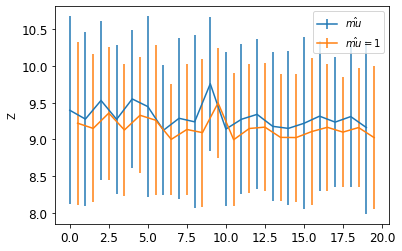

In [116]:
#plt.scatter(np.arange(len(Z_MLL)), np.asarray(Z_MLL))
plt.errorbar(np.arange(len(Z_MLL)), np.asarray(Z_MLL), np.asarray(Z_MLL_std), label = '$\hat{mu}$')
plt.errorbar(np.arange(len(Z_MLL_mu)) + 0.5, np.asarray(Z_MLL_mu), np.asarray(Z_MLL_std_mu), label =  '$\hat{mu} = 1$')
#plt.scatter(np.arange(len(Z_MLL)), np.asarray(Z_MLL_mu))
plt.legend()
plt.ylabel('Z')
plt.savefig('../graph/loopBP6_50000_KDEvariable_B_2.pdf')

## loop varying ML

In [117]:
lst = ['photon $p_T$ [GeV]', 'photon $\eta$', 'photon $\phi$', 'num photon',
       'jet $p_T$ [GeV]', 'jet $\eta$', 'jet $\phi$',
       'lepton $p_T$ [GeV]', 'lepton $\eta$', 'lepton $\phi$', 'num lepton', 'num_taus',
       'MET $p_T$ [GeV]', 'MET $\phi$',
       '$H_T$ [GeV]', '$H_T$ (jets) [GeV]', 'num_jets',
       '$S_T$ [GeV]', 
       'MET sig [GeV]',# '$m_{eff}$ [GeV]',
       '$m_T$ photon [GeV]', '$m_T$ jet [GeV]', '$m_T$ lepton [GeV]',
       #'$\Delta \phi$ (MET-photon)', '$\Delta \phi$ (MET-jet)', '$\Delta \phi$ (MET-lepton)', 
       #'$\Delta R$ (photon-jet)', '$\Delta R$ (photon-lepton)', '$\Delta R$ (lepton-jet)', 
       'SM=0 - NP=1']

0
0.9798991716720216


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
 27479.74290334 26476.64909901 25320.01099881 24014.85660213
 22539.89327027 20926.30167205 19143.52334197 17186.90781985
 15067.55154187 12743.53359771 10205.62247865  7487.20982833
  4563.81799128  1464.85163707 -1751.93966702 -4972.44374689]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [         -inf          -inf          -inf          -inf          -inf
          -inf          -inf          -inf         

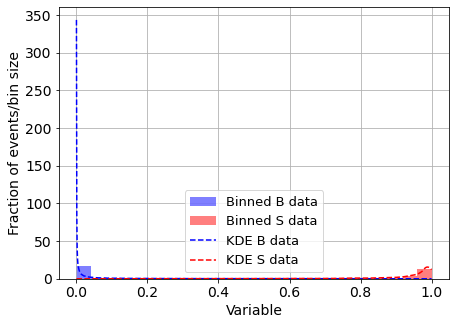

KDE Kernel:  epanechnikov
Background bandwidth:  0.0007122485584859914
Signal bandwidth:  0.022117541055781564
This may take a while...
1 done
2 done
3 done
4 done


100%|███████████████████████████████████| 50/50 [01:48<00:00,  2.18s/it]


Z:9.222354100826736
Z_std:0.9800863355845093
Z_1:8.966841905533709
Z_std_1:0.8168716449863945
1
0.9800137038297719


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
 27360.5569709  26386.81107071 25260.16429297 23988.07840776
 22574.24373407 20977.5438698  19224.10309234 17282.95322642
 15154.10292494 12805.33805832 10254.47821171  7513.48267083
  4597.42540073  1500.05992094 -1727.53189765 -4962.92101806]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [         -inf          -inf          -inf          -inf          -inf
          -inf          -inf          -inf         

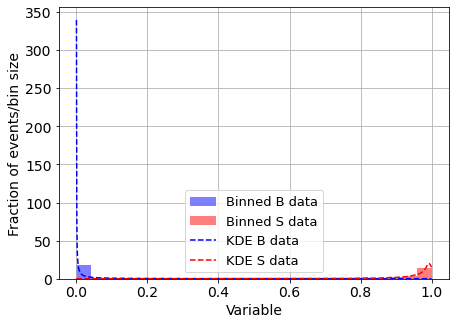

KDE Kernel:  epanechnikov
Background bandwidth:  0.0007122485584859914
Signal bandwidth:  0.013538761800225447
This may take a while...
1 done
2 done
3 done
4 done


100%|███████████████████████████████████| 50/50 [01:42<00:00,  2.04s/it]


Z:9.51124419528639
Z_std:1.0352056757126096
Z_1:9.341187493394031
Z_std_1:0.8858970411184919
2
0.9799195668993652


IOStream.flush timed out
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
 27712.65010821 26697.4769248  25531.54922647 24220.99216362
 22758.8561403  21132.24119675 19338.75803097 17375.52378298
 15205.29729197 12859.80274136 10307.28353104  7547.05693244
  4609.47461391  1504.8473679  -1733.19057586 -4966.99220632]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [         -inf          -inf          -inf          -inf          -inf
          -inf          -i

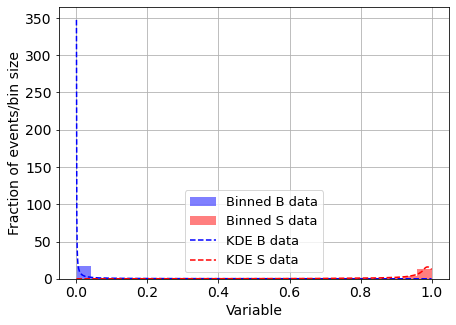

KDE Kernel:  epanechnikov
Background bandwidth:  0.0007122485584859914
Signal bandwidth:  0.022117541055781564
This may take a while...
1 done
2 done
3 done
4 done


100%|███████████████████████████████████| 50/50 [01:42<00:00,  2.05s/it]


Z:9.22870497502232
Z_std:1.0238621987462044
Z_1:8.999240031653326
Z_std_1:0.8187507808092482
3
0.9797328278479412


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf 26519.2934277  25338.13172206 24030.64151548
 22569.07492962 20954.15760237 19166.42658999 17184.47523599
 15030.66881006 12725.5199595  10215.33340582  7493.90784931
  4583.71301066  1484.24979884 -1746.66028207 -4966.93389247]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [         -inf          -inf          -inf          -inf          -inf
          -inf          -inf          -inf         

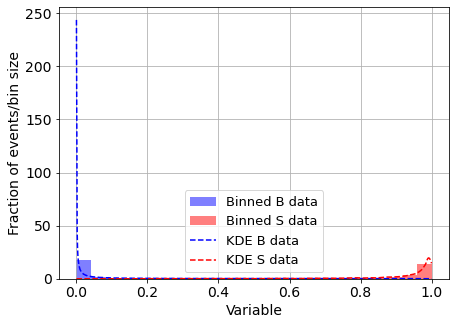

In [ ]:
bp = 5

Z_MLL        = []
Z_MLL_std    = []
Z_MLL_mu     = []
Z_MLL_std_mu = []

auc_total   = []
auc_wgamma  = []
auc_wjets   = []
auc_ttgamma = []
for iloop in range(10):
    
    print(iloop)
    nobs = np.min( (len(photon_SM), len(photon_NP[bp])) )
    df = pd.DataFrame()


    #np.random.seed(28890)

    SM_indices = np.random.choice(np.arange(len(photon_SM)), size = nobs, replace = False)

    df[lst[0]]= np.concatenate([photon_SM[SM_indices,0],photon_NP[bp][:nobs,0]])
    df[lst[1]]= np.concatenate([photon_SM[SM_indices,1],photon_NP[bp][:nobs,1]])
    df[lst[2]]= np.concatenate([photon_SM[SM_indices,2],photon_NP[bp][:nobs,2]])
    df[lst[3]]= np.concatenate([photon_SM[SM_indices,3],photon_NP[bp][:nobs,3]])

    df[lst[4]]= np.concatenate([jet_SM[SM_indices,0],jet_NP[bp][:nobs,0]])
    df[lst[5]]= np.concatenate([jet_SM[SM_indices,1],jet_NP[bp][:nobs,1]])
    df[lst[6]]= np.concatenate([jet_SM[SM_indices,2],jet_NP[bp][:nobs,2]])

    df[lst[7]]= np.concatenate([lepton_SM[SM_indices,0],lepton_NP[bp][:nobs,0]])
    df[lst[8]]= np.concatenate([lepton_SM[SM_indices,1],lepton_NP[bp][:nobs,1]])
    df[lst[9]]= np.concatenate([lepton_SM[SM_indices,2],lepton_NP[bp][:nobs,2]])
    df[lst[10]]= np.concatenate([lepton_SM[SM_indices,3],lepton_NP[bp][:nobs,3]])
    df[lst[11]]= np.concatenate([lepton_SM[SM_indices,4],lepton_NP[bp][:nobs,4]])

    df[lst[12]]= np.concatenate([MET_SM[SM_indices,0],MET_NP[bp][:nobs,0]])
    df[lst[13]]= np.concatenate([MET_SM[SM_indices,2],MET_NP[bp][:nobs,2]])

    df[lst[14]]= np.concatenate([hadinfo_SM[SM_indices,0],hadinfo_NP[bp][:nobs,0]])
    df[lst[15]]= np.concatenate([hadinfo_SM[SM_indices,1],hadinfo_NP[bp][:nobs,1]])
    df[lst[16]]= np.concatenate([hadinfo_SM[SM_indices,2],hadinfo_NP[bp][:nobs,2]])

    df[lst[17]]= np.concatenate([ST_SM[SM_indices], ST_NP[bp][:nobs]])
    df[lst[18]]= np.concatenate([MET_sig_SM[SM_indices], MET_sig_NP[bp][:nobs]])
    #df[lst[19]]= np.concatenate([m_eff_SM[SM_indices], m_eff_NP[bp][:nobs]])

    df[lst[19]]= np.concatenate([mT_photon_SM[SM_indices], mT_photon_NP[bp][:nobs]])
    df[lst[20]]= np.concatenate([mT_jet_SM[SM_indices], mT_jet_NP[bp][:nobs]])
    df[lst[21]]= np.concatenate([mT_lepton_SM[SM_indices], mT_lepton_NP[bp][:nobs]])


    df['bkg_flag']= np.concatenate( (bkg_flag[SM_indices], np.zeros(len(photon_NP[bp][:nobs]))) )

    df[lst[22]]= np.concatenate([np.zeros(len(photon_SM[SM_indices])), np.ones(len(photon_NP[bp][:nobs]))])

    df_array = np.asarray(df)
    
    df_test = pd.DataFrame()

    SM_indices = np.random.choice(np.arange(len(photon_SM_pool)), size = len(photon_SM_pool), replace = False)

    df_test[lst[0]]= np.concatenate([photon_SM_pool[SM_indices,0],photon_NP[bp][nobs:,0]])
    df_test[lst[1]]= np.concatenate([photon_SM_pool[SM_indices,1],photon_NP[bp][nobs:,1]])
    df_test[lst[2]]= np.concatenate([photon_SM_pool[SM_indices,2],photon_NP[bp][nobs:,2]])
    df_test[lst[3]]= np.concatenate([photon_SM_pool[SM_indices,3],photon_NP[bp][nobs:,3]])

    df_test[lst[4]]= np.concatenate([jet_SM_pool[SM_indices,0],jet_NP[bp][nobs:,0]])
    df_test[lst[5]]= np.concatenate([jet_SM_pool[SM_indices,1],jet_NP[bp][nobs:,1]])
    df_test[lst[6]]= np.concatenate([jet_SM_pool[SM_indices,2],jet_NP[bp][nobs:,2]])

    df_test[lst[7]]= np.concatenate([lepton_SM_pool[SM_indices,0],lepton_NP[bp][nobs:,0]])
    df_test[lst[8]]= np.concatenate([lepton_SM_pool[SM_indices,1],lepton_NP[bp][nobs:,1]])
    df_test[lst[9]]= np.concatenate([lepton_SM_pool[SM_indices,2],lepton_NP[bp][nobs:,2]])
    df_test[lst[10]]= np.concatenate([lepton_SM_pool[SM_indices,3],lepton_NP[bp][nobs:,3]])
    df_test[lst[11]]= np.concatenate([lepton_SM_pool[SM_indices,4],lepton_NP[bp][nobs:,4]])

    df_test[lst[12]]= np.concatenate([MET_SM_pool[SM_indices,0],MET_NP[bp][nobs:,0]])
    df_test[lst[13]]= np.concatenate([MET_SM_pool[SM_indices,2],MET_NP[bp][nobs:,2]])

    df_test[lst[14]]= np.concatenate([hadinfo_SM_pool[SM_indices,0],hadinfo_NP[bp][nobs:,0]])
    df_test[lst[15]]= np.concatenate([hadinfo_SM_pool[SM_indices,1],hadinfo_NP[bp][nobs:,1]])
    df_test[lst[16]]= np.concatenate([hadinfo_SM_pool[SM_indices,2],hadinfo_NP[bp][nobs:,2]])

    df_test[lst[17]]= np.concatenate([ST_SM_pool[SM_indices], ST_NP[bp][nobs:]])
    df_test[lst[18]]= np.concatenate([MET_sig_SM_pool[SM_indices], MET_sig_NP[bp][nobs:]])
    #df_test[lst[19]]= np.concatenate([m_eff_SM_pool[SM_indices], m_eff_NP[bp][nobs:]])

    df_test[lst[19]]= np.concatenate([mT_photon_SM_pool[SM_indices], mT_photon_NP[bp][nobs:]])
    df_test[lst[20]]= np.concatenate([mT_jet_SM_pool[SM_indices], mT_jet_NP[bp][nobs:]])
    df_test[lst[21]]= np.concatenate([mT_lepton_SM_pool[SM_indices], mT_lepton_NP[bp][nobs:]])


    df_test['bkg_flag_pool']= np.concatenate( (bkg_flag_pool[SM_indices], np.zeros(len(photon_NP[bp][nobs:]))) )

    df_test[lst[22]]= np.concatenate([np.zeros(len(photon_SM_pool[SM_indices])), np.ones(len(photon_NP[bp][nobs:]))])

    df_test_array = np.asarray(df_test)
    
    nobs = len(df_array)

    train_size = int(0.80 * nobs)
    val_size   = nobs - train_size #%- test_size 

    random_indices = np.random.choice(np.arange(nobs), size = nobs, replace = False)

    train_indices = random_indices[:train_size]
    val_indices   = random_indices[train_size:]
    
    
    X_train        = df_array[train_indices, :22]
    bkg_flag_train = df_array[train_indices, 22]
    y_mon_train    = df_array[train_indices, -1]

    X_test        = df_test_array[:, :22]
    bkg_flag_test = df_test_array[:, 22]
    y_mon_test    = df_test_array[:, -1]

    X_val        = df_array[val_indices, :22]
    bkg_flag_val = df_array[val_indices, 22]
    y_mon_val    = df_array[val_indices, -1]
    
    # to normalize
    x_scaler = preprocessing.MinMaxScaler()
    x_scaler = x_scaler.fit(X_train)

    X_mon_train = x_scaler.transform(X_train)
    X_mon_test  = x_scaler.transform(X_test)
    X_mon_val   = x_scaler.transform(X_val)
    
    
    # CLASSIFIER
    classifier = XGBClassifier(
        n_estimators  = 500,
        learning_rate = 0.1,
        reg_lambda    = 0.0, reg_alpha = 0.0,
        early_stopping_rounds = 50,#early stopping
        eval_metric = 'logloss',
        gamma = 0.0, objective = 'binary:logistic',
        max_depth = 5)

    # FIT
    classifier.fit(X_mon_train, y_mon_train, 
                   eval_set = [(X_mon_train, y_mon_train), (X_mon_val, y_mon_val)],
                   verbose  = False)

    # PREDICTIONS
    y_pred_xg = classifier.predict_proba(X_mon_test).T[1]

    pred_XG_NP = y_pred_xg[np.where(bkg_flag_test == 0)[0]]
    pred_XG_SM = y_pred_xg[np.where(bkg_flag_test != 0)[0]]
    
    
    # Let's estimate the ROC Curve
    nvals = 50
    tpr_total   = np.zeros(nvals) 
    fpr_total   = np.zeros(nvals) 
    tpr_ttgamma = np.zeros(nvals) 
    fpr_ttgamma = np.zeros(nvals) 
    tpr_wgamma  = np.zeros(nvals) 
    fpr_wgamma  = np.zeros(nvals) 
    tpr_wjets   = np.zeros(nvals) 
    fpr_wjets   = np.zeros(nvals) 

    for ith, th in enumerate(np.linspace(0,1, nvals)):
        tp = np.where( (bkg_flag_test == 0) & (y_pred_xg > th) )[0]
        tn = np.where( (bkg_flag_test != 0) & (y_pred_xg < th) )[0]
        fp = np.where( (bkg_flag_test != 0) & (y_pred_xg > th) )[0]
        fn = np.where( (bkg_flag_test == 0) & (y_pred_xg < th) )[0]

        tpr_total[ith] = len(tp) / (len(tp) + len(fn))
        fpr_total[ith] = len(fp) / (len(fp) + len(tn))

        tp = np.where( (bkg_flag_test == 0) & (y_pred_xg > th) )[0]
        tn = np.where( (bkg_flag_test == 1) & (y_pred_xg < th) )[0]
        fp = np.where( (bkg_flag_test == 1) & (y_pred_xg > th) )[0]
        fn = np.where( (bkg_flag_test == 0) & (y_pred_xg < th) )[0]

        tpr_wgamma[ith] = len(tp) / (len(tp) + len(fn))
        fpr_wgamma[ith] = len(fp) / (len(fp) + len(tn))

        tp = np.where( (bkg_flag_test == 0) & (y_pred_xg > th) )[0]
        tn = np.where( (bkg_flag_test == 2) & (y_pred_xg < th) )[0]
        fp = np.where( (bkg_flag_test == 2) & (y_pred_xg > th) )[0]
        fn = np.where( (bkg_flag_test == 0) & (y_pred_xg < th) )[0]

        tpr_wjets[ith] = len(tp) / (len(tp) + len(fn))
        fpr_wjets[ith] = len(fp) / (len(fp) + len(tn))

        tp = np.where( (bkg_flag_test == 0) & (y_pred_xg > th) )[0]
        tn = np.where( (bkg_flag_test == 3) & (y_pred_xg < th) )[0]
        fp = np.where( (bkg_flag_test == 3) & (y_pred_xg > th) )[0]
        fn = np.where( (bkg_flag_test == 0) & (y_pred_xg < th) )[0]

        tpr_ttgamma[ith] = len(tp) / (len(tp) + len(fn))
        fpr_ttgamma[ith] = len(fp) / (len(fp) + len(tn))
    auc_ttgamma.append( auc(fpr_ttgamma, tpr_ttgamma) )
    auc_wjets.append( auc(fpr_wjets, tpr_wjets) )
    auc_wgamma.append( auc(fpr_wgamma, tpr_wgamma) )
    auc_total.append( auc(fpr_total, tpr_total) )
    
    
    print('AUC:' + str(auc_total[iloop]))
    
    kde_bkg, kde_sig, norm_factor_SM, norm_factor_NP, B_bandwidth, S_bandwidth = KDE_fitter(pred_XG_SM, pred_XG_NP, 
                                                                                            50000, # Numero de datos para fitear
                                                                                            np.logspace(-4.0, 0.05, 20), 
                                                                                            set_kernel='epanechnikov')
    print('This may take a while...')

    pB_B_data = np.exp(kde_bkg.score_samples(np.c_[pred_XG_SM, np.zeros(len(pred_XG_SM)) ]) )
    print('1 done')
    pS_B_data = np.exp(kde_sig.score_samples(np.c_[pred_XG_SM, np.ones(len(pred_XG_SM)) ]) )
    print('2 done')

    # Normalize
    pB_B_data = pB_B_data / norm_factor_SM
    pS_B_data = pS_B_data / norm_factor_NP
    
    pB_S_data = np.exp(kde_bkg.score_samples(np.c_[pred_XG_NP, np.zeros(len(pred_XG_NP)) ]) )
    print('3 done')
    pS_S_data = np.exp(kde_sig.score_samples(np.c_[pred_XG_NP, np.ones(len(pred_XG_NP)) ]) )
    print('4 done')

    # Normalize
    pB_S_data = pB_S_data / norm_factor_SM
    pS_S_data = pS_S_data / norm_factor_NP
    
    # indeces (to later build a random pseudo experiment)
    indices_B = [i for i in range(len(pS_B_data))]
    indices_S = [i for i in range(len(pS_S_data))]
    # loop over the number of pseudo experiments
    #np.random.seed(91218)

    muhat_selected_MLL_list = []
    q_muhat_MLL = []
    q_muhat_MLL_mu = []
    for its in tqdm(range(50)):

        # this pseudo-exp has B_rand number of B events
        B_rand = np.random.poisson(int(B_expected))

        ran_ind = np.random.choice(indices_B, B_rand)

        pB_B_data_shuf = []
        pS_B_data_shuf = []

        # for each event x_i in the pseudo, save pb(o(x_i)) and ps(o(x_i)) (notice its the same x_i for pb and ps)
        for i in ran_ind:
            pB_B_data_shuf.append(pB_B_data[i])
            pS_B_data_shuf.append(pS_B_data[i])

        pB_B_data_shuf  = np.array(pB_B_data_shuf)
        pS_B_data_shuf  = np.array(pS_B_data_shuf)



        # this pseudo-exp has S_rand number of S events
        S_rand = np.random.poisson(int(S_expected[bp]))

        ran_ind = np.random.choice(indices_S, S_rand)

        pB_S_data_shuf = []
        pS_S_data_shuf = []

        # for each event x_i in the pseudo, save pb(o(x_i)) and ps(o(x_i)) (notice its the same x_i for pb and ps)
        for i in ran_ind:
            pB_S_data_shuf.append(pB_S_data[i])
            pS_S_data_shuf.append(pS_S_data[i])

        pB_S_data_shuf  = np.array(pB_S_data_shuf)
        pS_S_data_shuf  = np.array(pS_S_data_shuf)

        # p_b(o(x_ensemble)) =  concatenate: p_b(o(B_ensemble)) and p_b(o(S_ensemble)) 
        prob_x_given_B = np.concatenate([pB_B_data_shuf,pB_S_data_shuf])

        # p_s(o(x_ensemble)) =  concatenate: p_s(o(B_ensemble)) and p_s(o(S_ensemble)) 
        prob_x_given_S = np.concatenate([pS_B_data_shuf,pS_S_data_shuf])



        # NOW WE HAVE p_{s,b}(x_ensemble) for this particular pseudo_experiment

        # approximation: mu_hat=1 (discovery)
        q_muhat_MLL_mu.append( 2 * ( ( -1. * int(S_expected[bp])) + sum( [np.log( 1 + ( (1.*int(S_expected[bp])/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )



        # ESTIMATE mu_hat for this particular ensemble (implicit equation)
        B_prob_x_given_B = [x * B_expected for x in prob_x_given_B]

        # reference points
        sum_muhat_zero = sum ( [(x*1.) / ( (x * (0) * int(S_expected[bp])) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )
        sum_muhat_two = sum ( [(x*1.) / ( (x * 2. * int(S_expected[bp])) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )


        # we need (implicit eq. for mu_hat) = 1
        # conditions considering the reference points
        if (sum_muhat_zero < sum_muhat_two < 1) or (1 < sum_muhat_two < sum_muhat_zero):
            print('muhat = 2.1')
            muhat_selected_MLL = 2.1

            print(r'<p_{b}(Sdata)> = ' + str(np.mean(pB_S_data_shuf)))
            print(r'<p_{s}(Sdata)> = ' + str(np.mean(pS_S_data_shuf)))
            print(r'<p_{b}(Bdata)> = ' + str(np.mean(pB_B_data_shuf)))
            print(r'<p_{s}(Bdata)> = ' + str(np.mean(pS_B_data_shuf)))

        elif (sum_muhat_two < sum_muhat_zero < 1) or (1 < sum_muhat_zero < sum_muhat_two):
            print('muhat = -0.1')
            muhat_selected_MLL = -0.1

            print(r'<p_{b}(Sdata)> = ' + str(np.mean(pB_S_data_shuf)))
            print(r'<p_{s}(Sdata)> = ' + str(np.mean(pS_S_data_shuf)))
            print(r'<p_{b}(Bdata)> = ' + str(np.mean(pB_B_data_shuf)))
            print(r'<p_{s}(Bdata)> = ' + str(np.mean(pS_B_data_shuf)))

        elif sum_muhat_zero < 1 < sum_muhat_two:
            #print('muhat ~ 1')

            # grid, mu_hat is around 1
            muhat_test = np.arange(0, 2., 0.05)

            for vv in range(len(muhat_test)):

                mu_hat_condition_equal_1 = sum ( [(x*1.) / ( (x * muhat_test[vv] * int(S_expected[bp])) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

                if mu_hat_condition_equal_1 > 1:
                    muhat_selected_MLL = muhat_test[vv]
                    break

        elif sum_muhat_two < 1 < sum_muhat_zero:
            #print('muhat ~ 1')

            # grid, mu_hat is around 1
            muhat_test = np.arange(0, 2., 0.05)

            for vv in range(len(muhat_test)):

                mu_hat_condition_equal_1 = sum ( [(x*1.) / ( (x * muhat_test[vv] * int(S_expected[bp])) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

                if mu_hat_condition_equal_1 < 1:
                    muhat_selected_MLL = muhat_test[vv]
                    break


        # save the computed mu_hat (within range) for each pseudo_experiment
        muhat_selected_MLL_list.append(muhat_selected_MLL)


        # compute the test statistic for each pseudo_exp considering mu_hat
        if muhat_selected_MLL > 0:
            q_muhat_MLL.append( 2 * ( (-1.*muhat_selected_MLL * int(S_expected[bp])) + sum( [np.log( 1 + ( (muhat_selected_MLL*int(S_expected[bp])/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )

        else:
            q_muhat_MLL.append( 0 )



    # With the calculation of mu_hat
    muhat_mean_MLL = np.mean(muhat_selected_MLL_list)
    Z_MLL_aux = abs( np.median(q_muhat_MLL) )**0.5
    Z_MLL.append( Z_MLL_aux )
    Z_MLL_std.append( np.std(q_muhat_MLL) / (2.*Z_MLL_aux) )


    # With the approximation of mu_hat
    Z_MLL_mu_aux = abs( np.median(q_muhat_MLL_mu) )**0.5
    Z_MLL_mu.append( Z_MLL_mu_aux )
    Z_MLL_std_mu.append( np.std(q_muhat_MLL_mu) / (2.*Z_MLL_mu_aux) )
    
    print('Z:' + str(Z_MLL[iloop]))
    print('Z_std:' + str(Z_MLL_std[iloop]))
    print('Z_1:' + str(Z_MLL_mu[iloop]))
    print('Z_std_1:' + str(Z_MLL_std_mu[iloop]))

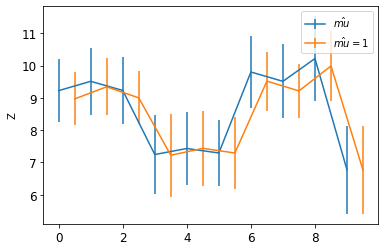

In [122]:
#plt.scatter(np.arange(len(Z_MLL)), np.asarray(Z_MLL))
plt.errorbar(np.arange(len(Z_MLL)), np.asarray(Z_MLL), np.asarray(Z_MLL_std), label = '$\hat{mu}$')
plt.errorbar(np.arange(len(Z_MLL_mu)) + 0.5, np.asarray(Z_MLL_mu), np.asarray(Z_MLL_std_mu), label =  '$\hat{mu} = 1$')
#plt.scatter(np.arange(len(Z_MLL)), np.asarray(Z_MLL_mu))
plt.legend()
plt.ylabel('Z')
plt.savefig('../graph/loopBP6_50000_MLLvariable.pdf')